# Tracking Success: Cohort Analysis of Marketing Expenditure in Yandex Afisha

**Analyst: Ica Candra Rambadiana** <br>
Febuary 2023 <br>
<br>
**Reviewed by Warrie Warrie**<br>
*DSNai - Data Science Nigeria | Machine Learning Engineer | GIS Data Specialist*<br>

<div class="alert alert-block alert-success">
<b>Reviewer's comment v3</b> <a class="tocSkip"></a>
    
I like that you wrote such in-depth conclusions on the whole study, proved them with numbers and made logical assumptions. Thank you for your work! It's really great! 👏👏👏 ✅       
</div>

<div class="alert alert-block alert-success">
<b>OVERALL REVIEWER'S COMMENT V3</b> <a class="tocSkip"></a>

Congratulation Ica on completing your project!!👏 <br>
    
Your work rate and improvement has been great and tremendous. I enjoy the fact that you were more detailed with your work with great depth of communication.  Your diligent to feedback is a big foster for growth <br> Keep it up 👏 <br> Technically, everything is Ok and you have shown good knowledge with business analytics idea.
    

Thank you and Good luck on your future projects 🥳

## INTRODUCTION

I've been offered an internship in the analytical department at Yandex Afisha. Yandex Afisha ("playbill") is part of the business unit of Yandex Company (ru) in the field of Entertainment Services. It allows users to buy online tickets to cinemas, theaters, and concerts. 

The Marketing Department gave me the task of optimizing marketing expenses. Here I had access for:
- server logs with data on Y.Afisha visits from June 2017 through May 2018
- Dump file with all orders for the period
- Marketing expenses statistics

### Objective
The analysis objective is:
- Get to know how people use the product
- When they start to buy
- How much money each customer brings
- When they pay off

### STAGES
This analysis will be divided into three main stages.
 1. STAGE 1 - Get Started
 2. STAGE 2 - Data Preprocessing
 3. STAGE 3 - Cohort Analysis<br>
    3.1. Product Analysis (user behaviors, retention rate, churn rate)<br>
    3.2. Sales Analysis (conversion rate, purchase size, LTV)<br>
    3.3. Marketing Analysis (Marketing costs, CAC, ROMI)

## STAGE 1 - Get Started

In [1]:
# import libraries
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
import seaborn as sns
sns.set(font_scale=1.5)

import plotly.express as px
from datetime import datetime

import warnings
warnings.filterwarnings('ignore')

In [2]:
# retrieve all datasets
# adjust dtypes in all columns for optimization

try:
    visits = pd.read_csv('/datasets/visits_log_us.csv',
                         dtype={'Device':'category'},
                         parse_dates=['End Ts', 'Start Ts']
                        )
    orders = pd.read_csv('/datasets/orders_log_us.csv',  parse_dates=['Buy Ts'])
    costs = pd.read_csv('/datasets/costs_us.csv', parse_dates=['dt'])

    
except:  
    visits = pd.read_csv('visits_log_us.csv',
                         dtype={'Device':'category'},
                         parse_dates=['End Ts', 'Start Ts']
                        )
    orders = pd.read_csv('orders_log_us.csv',  parse_dates=['Buy Ts'])
    costs = pd.read_csv('costs_us.csv', parse_dates=['dt'])

## STAGE 2 - Data Preprocessing

### Main Datasets

#### `visits`

The `visits` table (server logs with data on website visits):
1. `Uid` — user's unique identifier
2. `Device` — user's device
3. `Start Ts` — session start date and time
4. `End Ts` — session end date and time
5. `Source Id` — identifier of the ad source the user came from

In [3]:
# check `visits` dataset
visits.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   Device     359400 non-null  category      
 1   End Ts     359400 non-null  datetime64[ns]
 2   Source Id  359400 non-null  int64         
 3   Start Ts   359400 non-null  datetime64[ns]
 4   Uid        359400 non-null  uint64        
dtypes: category(1), datetime64[ns](2), int64(1), uint64(1)
memory usage: 11.3 MB


In [4]:
# detect duplicates
visits.duplicated().sum()

0

In [5]:
# check datetime range
visits['Start Ts'].describe()

count                  359400
unique                 224303
top       2017-11-24 16:06:00
freq                       19
first     2017-06-01 00:01:00
last      2018-05-31 23:59:00
Name: Start Ts, dtype: object

In [6]:
# check datetime range
visits['End Ts'].describe()

count                  359400
unique                 224760
top       2017-11-24 16:51:00
freq                       23
first     2017-06-01 00:02:00
last      2018-06-01 01:26:00
Name: End Ts, dtype: object

In [7]:
# check distribution of unique values in 'source_id'
visits['Source Id'].value_counts(ascending=False, normalize=True)

4     0.283233
3     0.238203
5     0.186157
2     0.132515
1     0.094939
9     0.036942
10    0.027894
7     0.000100
6     0.000017
Name: Source Id, dtype: float64

In [8]:
# check distribution of unique values in 'device'
visits['Device'].value_counts(ascending=False, normalize=True)

desktop    0.73057
touch      0.26943
Name: Device, dtype: float64

**FINDINGS:**<br>
- All columns have appropriate Dtype, no missing values, and no duplicates.
- For convenience, the columns' names need to be lowercase
- The dataset ranges from `2017-06-01 00:01:00` to `2018-05-31 23:59:00` (June 2017 - May 2018).<br> However, the last session was up to `2018-06-01 01:26:00`(June 2018).
- `Source_Id`column consisted of 9 marketing channels, which are 1,2,3,4,5,6,7,9,10
- `Device` columns consisted of 2 types, which are `touch` and `desktop`
- Both `Source_Id` and `Device` categories don't have the same proportion

In [9]:
# adjust columns name
visits = visits.rename(columns=str.lower)
visits = visits.rename(columns={'end ts':'end_ts',
                                'source id':'source_id',
                                'start ts':'start_ts'})
visits.columns

Index(['device', 'end_ts', 'source_id', 'start_ts', 'uid'], dtype='object')

In [10]:
# retrieve 'visits' dataset
visits.head()

device              end_ts  source_id            start_ts  \
0    touch 2017-12-20 17:38:00          4 2017-12-20 17:20:00   
1  desktop 2018-02-19 17:21:00          2 2018-02-19 16:53:00   
2    touch 2017-07-01 01:54:00          5 2017-07-01 01:54:00   
3  desktop 2018-05-20 11:23:00          9 2018-05-20 10:59:00   
4  desktop 2017-12-27 14:06:00          3 2017-12-27 14:06:00   

                    uid  
0  16879256277535980062  
1    104060357244891740  
2   7459035603376831527  
3  16174680259334210214  
4   9969694820036681168

#### `orders`

The orders table (data on orders):
1. `Uid` — unique identifier of the user making an order
2. `Buy Ts` — order date and time
3. `Revenue` — Y.Afisha's revenue from the order (usd)

In [11]:
# check `orders` datasets
orders.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   Buy Ts   50415 non-null  datetime64[ns]
 1   Revenue  50415 non-null  float64       
 2   Uid      50415 non-null  uint64        
dtypes: datetime64[ns](1), float64(1), uint64(1)
memory usage: 1.2 MB


In [12]:
# detect duplicates
orders.duplicated().sum()

0

In [13]:
# check datetime range
orders['Buy Ts'].describe()

count                   50415
unique                  45991
top       2018-05-31 10:13:00
freq                        9
first     2017-06-01 00:10:00
last      2018-06-01 00:02:00
Name: Buy Ts, dtype: object

**FINDINGS:**<br>
- All columns have appropriate Dtype, no missing values, and no duplicates
- The dataset ranges from `2017-06-01 00:10:00` to `2018-06-01 00:02:00` (June 2017 - June 2018)
- For convenience, the columns' names need to be lowercase 
- We will drop the data from June 2018

In [14]:
# adjust columns name
orders = orders.rename(columns=str.lower)
orders = orders.rename(columns={'buy ts':'buy_ts'})

orders.columns

Index(['buy_ts', 'revenue', 'uid'], dtype='object')

In [15]:
# drop data from June 2018
orders['order_month'] = orders['buy_ts'].astype('datetime64[M]')
orders = orders.loc[~(orders['order_month'] == '2018-06-01')]

In [16]:
# ensure the last order is May 2018
orders['buy_ts'].describe()

count                   50414
unique                  45990
top       2018-05-31 10:13:00
freq                        9
first     2017-06-01 00:10:00
last      2018-05-31 23:56:00
Name: buy_ts, dtype: object

In [17]:
# retrieve 'orders' dataset
orders.head()

buy_ts  revenue                   uid order_month
0 2017-06-01 00:10:00    17.00  10329302124590727494  2017-06-01
1 2017-06-01 00:25:00     0.55  11627257723692907447  2017-06-01
2 2017-06-01 00:27:00     0.37  17903680561304213844  2017-06-01
3 2017-06-01 00:29:00     0.55  16109239769442553005  2017-06-01
4 2017-06-01 07:58:00     0.37  14200605875248379450  2017-06-01

#### `costs`

The costs table (data on marketing expenses):
1. `source_id` — ad source identifier
2. `dt` — date
3. `costs` — expenses on this ad source on this day

In [18]:
# check `costs` datasets
costs.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   source_id  2542 non-null   int64         
 1   dt         2542 non-null   datetime64[ns]
 2   costs      2542 non-null   float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 59.7 KB


In [19]:
# detect duplicates
costs.duplicated().sum()

0

In [20]:
# check distribution of unique values in 'source_id'
costs['source_id'].value_counts(ascending=False, normalize=True)

5     0.143194
2     0.142801
4     0.142801
10    0.142801
1     0.142801
3     0.142801
9     0.142801
Name: source_id, dtype: float64

In [21]:
# check datetime range
costs['dt'].describe()

count                    2542
unique                    364
top       2017-06-28 00:00:00
freq                        7
first     2017-06-01 00:00:00
last      2018-05-31 00:00:00
Name: dt, dtype: object

**FINDINGS:**<br>
- All columns have appropriate Dtype, no missing values, and no duplicates.
- The dataset ranges from `2017-06-01 00:00:00` to `2018-05-31 00:00:00` (June 2017 - May 2018)
- The proportion of the source_id is always  the same

In [22]:
# retrieve 'costs' dataset
costs.head()

source_id         dt  costs
0          1 2017-06-01  75.20
1          1 2017-06-02  62.25
2          1 2017-06-03  36.53
3          1 2017-06-04  55.00
4          1 2017-06-05  57.08

### Additional Datasets

#### `first_visit`
`first_visit` contains datetime data when each user_id visited the platform for the first time 

In [23]:
# initialize first_visit variable
# group `start_ts` by `uid`
first_visit = visits.groupby('uid')['start_ts'].min()

# rename series object
first_visit.name = 'first_visit'

# check the result
first_visit

uid
11863502262781         2018-03-01 17:27:00
49537067089222         2018-02-06 15:55:00
297729379853735        2017-06-07 18:47:00
313578113262317        2017-09-18 22:49:00
325320750514679        2017-09-30 14:29:00
                               ...        
18446403737806311543   2017-11-30 03:36:00
18446424184725333426   2017-12-06 20:32:00
18446556406699109058   2018-01-01 16:29:00
18446621818809592527   2017-12-27 13:27:00
18446676030785672386   2017-10-04 16:01:00
Name: first_visit, Length: 228169, dtype: datetime64[ns]

#### `first_order`
`first_order` contains datetime data when each user_id made the first order

In [24]:
# initialize `first_order`
first_order = orders.groupby('uid')['buy_ts'].min()
first_order.name = 'first_order'
first_order

uid
313578113262317        2018-01-03 21:51:00
1575281904278712       2017-06-03 10:13:00
2429014661409475       2017-10-11 18:33:00
2464366381792757       2018-01-28 15:54:00
2551852515556206       2017-11-24 10:14:00
                               ...        
18445147675727495770   2017-11-24 09:03:00
18445407535914413204   2017-09-22 23:55:00
18445601152732270159   2018-03-26 22:54:00
18446156210226471712   2018-02-18 19:34:00
18446167067214817906   2017-10-17 10:16:00
Name: first_order, Length: 36522, dtype: datetime64[ns]

#### `orders_source`
`orders_source` summarize all of the `source_id`s used by each `uid` and count the number of orders they make in one day

In [25]:
# build `orders_source` reference
# merge `orders` and `visits`
# filter where the orders['buy_ts'] of an `uid` between the visits session (visits['start_ts'] and visits['end_ts'])
# take only relevant columns

orders_source = (orders.merge(visits, on='uid', how='left')
                       .loc[lambda df: df['buy_ts'].between(df['start_ts'], df['end_ts'])]
                       [['uid', 'source_id', 'buy_ts']]
                )

orders_source

uid  source_id              buy_ts
0       10329302124590727494          1 2017-06-01 00:10:00
1       11627257723692907447          2 2017-06-01 00:25:00
2       17903680561304213844          2 2017-06-01 00:27:00
3       16109239769442553005          2 2017-06-01 00:29:00
4       14200605875248379450          3 2017-06-01 07:58:00
...                      ...        ...                 ...
761789  15576344609395725707         10 2018-05-31 23:40:00
761790  15854392578508828030          4 2018-05-31 23:42:00
761798  12296626599487328624          4 2018-05-31 23:50:00
761800  11369640365507475976         10 2018-05-31 23:50:00
761801   1786462140797698849          3 2018-05-31 23:54:00

[35926 rows x 3 columns]

### Enrich Main Datasets with Additional Datasets

#### `visits_clean`

`visits_clean` was the enriched data frame of the `visits`.

In [26]:
# add columns 'first_visit' by joining the series to df `visits`
visits_clean = visits.join(first_visit, on='uid')

# check the result
visits_clean.head()

device              end_ts  source_id            start_ts  \
0    touch 2017-12-20 17:38:00          4 2017-12-20 17:20:00   
1  desktop 2018-02-19 17:21:00          2 2018-02-19 16:53:00   
2    touch 2017-07-01 01:54:00          5 2017-07-01 01:54:00   
3  desktop 2018-05-20 11:23:00          9 2018-05-20 10:59:00   
4  desktop 2017-12-27 14:06:00          3 2017-12-27 14:06:00   

                    uid         first_visit  
0  16879256277535980062 2017-12-20 17:20:00  
1    104060357244891740 2018-02-19 16:53:00  
2   7459035603376831527 2017-07-01 01:54:00  
3  16174680259334210214 2018-03-09 20:05:00  
4   9969694820036681168 2017-12-27 14:06:00

In [27]:
# ensure the total rows is the same
print(len(visits), len(visits_clean))

359400 359400


In [28]:
# add column 'session_date'
visits_clean['session_date'] = visits_clean['start_ts'].astype('datetime64[D]')

In [29]:
# add column `session_week`
visits_clean['session_week'] = visits_clean['start_ts'].astype('datetime64[W]')

# add column `session_year`
visits_clean['session_year'] = visits_clean['start_ts'].astype('datetime64[Y]')

In [30]:
visits_clean['session_week']

0        2017-12-14
1        2018-02-15
2        2017-06-29
3        2018-05-17
4        2017-12-21
            ...    
359395   2017-07-27
359396   2018-01-25
359397   2018-03-01
359398   2017-11-02
359399   2017-09-07
Name: session_week, Length: 359400, dtype: datetime64[ns]

In [31]:
# add column 'week_visit'
visits_clean['week_visit'] = (pd.to_datetime(visits_clean['start_ts'], unit='d')
                            - pd.to_timedelta(visits_clean['start_ts'].dt.dayofweek, unit='d')
                           )

# add column 'first_week_visit'
visits_clean['first_week_visit'] = (pd.to_datetime(visits_clean['first_visit'], unit='d')
                                  - pd.to_timedelta(visits_clean['first_visit'].dt.dayofweek, unit='d')
                                 )

In [32]:
# add column 'month_visit'
visits_clean['month_visit'] = visits_clean['start_ts'].astype('datetime64[M]')

# add column 'first_month_visit'
visits_clean['first_month_visit'] = visits_clean['first_visit'].astype('datetime64[M]')

In [33]:
# add column 'lifetime_week'
visits_clean['lifetime_week'] = (visits_clean['week_visit'] - visits_clean['first_week_visit'])/ np.timedelta64(1, 'W')                          
visits_clean['lifetime_week'] = round(visits_clean['lifetime_week']).astype('int')

# add column 'lifetime_month'
visits_clean['lifetime_month'] = (visits_clean['start_ts'] - visits_clean['first_visit'])/ np.timedelta64(1, 'M')                          
visits_clean['lifetime_month'] = round(visits_clean['lifetime_month']).astype('int')

In [34]:
# format datetime
visits_clean['month_visit'] = visits_clean['month_visit'].dt.strftime('%Y-%m')
visits_clean['first_month_visit'] = visits_clean['first_month_visit'].dt.strftime('%Y-%m')

visits_clean['week_visit'] = visits_clean['week_visit'].dt.strftime('%Y-%m-%d')
visits_clean['first_week_visit'] = visits_clean['first_week_visit'].dt.strftime('%Y-%m-%d')

In [35]:
# check the result
visits_clean.head(2)

device              end_ts  source_id            start_ts  \
0    touch 2017-12-20 17:38:00          4 2017-12-20 17:20:00   
1  desktop 2018-02-19 17:21:00          2 2018-02-19 16:53:00   

                    uid         first_visit session_date session_week  \
0  16879256277535980062 2017-12-20 17:20:00   2017-12-20   2017-12-14   
1    104060357244891740 2018-02-19 16:53:00   2018-02-19   2018-02-15   

  session_year  week_visit first_week_visit month_visit first_month_visit  \
0   2017-01-01  2017-12-18       2017-12-18     2017-12           2017-12   
1   2018-01-01  2018-02-19       2018-02-19     2018-02           2018-02   

   lifetime_week  lifetime_month  
0              0               0  
1              0               0

#### `orders_clean`
`orders_clean` was the enriched data frame of the `orders`.

In [36]:
orders_clean = (orders.merge(orders_source,
                           on=['buy_ts', 'uid'],
                           how='left',
                           validate='one_to_one')
             )
orders_clean

buy_ts  revenue                   uid order_month  \
0     2017-06-01 00:10:00    17.00  10329302124590727494  2017-06-01   
1     2017-06-01 00:25:00     0.55  11627257723692907447  2017-06-01   
2     2017-06-01 00:27:00     0.37  17903680561304213844  2017-06-01   
3     2017-06-01 00:29:00     0.55  16109239769442553005  2017-06-01   
4     2017-06-01 07:58:00     0.37  14200605875248379450  2017-06-01   
...                   ...      ...                   ...         ...   
50409 2018-05-31 23:43:00     3.67   1805512004303848280  2018-05-01   
50410 2018-05-31 23:50:00     4.64  12296626599487328624  2018-05-01   
50411 2018-05-31 23:50:00     5.80  11369640365507475976  2018-05-01   
50412 2018-05-31 23:54:00     0.30   1786462140797698849  2018-05-01   
50413 2018-05-31 23:56:00     3.67   3993697860786194247  2018-05-01   

       source_id  
0            1.0  
1            2.0  
2            2.0  
3            2.0  
4            3.0  
...          ...  
50409        NaN  
50410        4.0  
50411       10.0  
50412        3.0  
50413        NaN  

[50414 rows x 5 columns]

**NOTE:**
- After checking, we found that most of the `uid` containing NaN values have the `buy_ts` that are not between `start_ts` and `end_ts`
- This may happen because the orders were made from other sources or tracking system failure.
- In this case, we will assume the system was mistaken for detecting the end session since the users might switch the window while using the platform
- We will try to fill the NaN value by matching it with the nearest `end_ts`, where `buy_ts` happened after `end_ts`

In [37]:
# filter nan rows
nan_orders_clean = orders_clean.loc[orders_clean['source_id'].isna()]
nan_orders_clean

buy_ts  revenue                   uid order_month  \
26    2017-06-01 14:20:00     1.47   4899721912549460321  2017-06-01   
33    2017-06-01 16:31:00     2.08   2050423809815667474  2017-06-01   
46    2017-06-01 18:11:00     2.44  18346008462625591446  2017-06-01   
54    2017-06-01 19:39:00     0.18  13004013926921717095  2017-06-01   
58    2017-06-01 20:21:00     1.40  10303622633602341332  2017-06-01   
...                   ...      ...                   ...         ...   
50401 2018-05-31 23:14:00     0.30   5877288373018804921  2018-05-01   
50402 2018-05-31 23:29:00     2.75    656193162812616454  2018-05-01   
50406 2018-05-31 23:40:00     1.16  13121453305610619664  2018-05-01   
50409 2018-05-31 23:43:00     3.67   1805512004303848280  2018-05-01   
50413 2018-05-31 23:56:00     3.67   3993697860786194247  2018-05-01   

       source_id  
26           NaN  
33           NaN  
46           NaN  
54           NaN  
58           NaN  
...          ...  
50401        NaN  
50402        NaN  
50406        NaN  
50409        NaN  
50413        NaN  

[14488 rows x 5 columns]

In [38]:
# create reference to fill NaN in `nan_new_orders`

# 1. merge `nan_orders_clean` with 'visits' to get `source_id`
# 2. filter where buy time > time leave
# 3. calculate the time different

nan_orders_clean_diff = (
    nan_orders_clean
    .drop(columns='source_id')
    .merge(visits, how='left', on='uid')
    .loc[lambda df: df.end_ts < df.buy_ts]
    .assign(time_diff=lambda df: df.buy_ts - df.end_ts)
)

# 4. initialize new reference to get min time different
min_diff = (
    nan_orders_clean_diff
    .groupby(['buy_ts', 'uid'], as_index=False)
    [['time_diff']]
    .min()
)

# 5. merge `nan_orders_clean_diff` and `min_diff`
nan_orders_source = (
    nan_orders_clean_diff
    .merge(min_diff, on=['buy_ts', 'uid'], suffixes=('', '_min'))
    .loc[lambda df: df['time_diff'] == df['time_diff_min']]
)

nan_orders_source.head(2)

buy_ts  revenue                  uid order_month   device  \
0 2017-06-01 14:20:00     1.47  4899721912549460321  2017-06-01  desktop   
2 2017-06-01 16:31:00     2.08  2050423809815667474  2017-06-01  desktop   

               end_ts  source_id            start_ts       time_diff  \
0 2017-06-01 12:16:00          3 2017-06-01 11:32:00 0 days 02:04:00   
2 2017-06-01 15:10:00          1 2017-06-01 14:56:00 0 days 01:21:00   

    time_diff_min  
0 0 days 02:04:00  
2 0 days 01:21:00

In [39]:
# check the row
print(len(nan_orders_clean), len(nan_orders_source))

14488 14488


In [40]:
# merge `nan_orders_clean` and `orders_clean`
orders_clean = (
    orders_clean
    .merge(nan_orders_source[['uid', 'buy_ts', 'source_id']],
           how='left',
           on=['uid', 'buy_ts'])
    .fillna(method='ffill')
    .drop(columns=['source_id_y'])
    .rename(columns={'source_id_x':'source_id'})
)

orders_clean['source_id'] = orders_clean['source_id'].astype('int')
orders_clean

buy_ts  revenue                   uid order_month  \
0     2017-06-01 00:10:00    17.00  10329302124590727494  2017-06-01   
1     2017-06-01 00:25:00     0.55  11627257723692907447  2017-06-01   
2     2017-06-01 00:27:00     0.37  17903680561304213844  2017-06-01   
3     2017-06-01 00:29:00     0.55  16109239769442553005  2017-06-01   
4     2017-06-01 07:58:00     0.37  14200605875248379450  2017-06-01   
...                   ...      ...                   ...         ...   
50409 2018-05-31 23:43:00     3.67   1805512004303848280  2018-05-01   
50410 2018-05-31 23:50:00     4.64  12296626599487328624  2018-05-01   
50411 2018-05-31 23:50:00     5.80  11369640365507475976  2018-05-01   
50412 2018-05-31 23:54:00     0.30   1786462140797698849  2018-05-01   
50413 2018-05-31 23:56:00     3.67   3993697860786194247  2018-05-01   

       source_id  
0              1  
1              2  
2              2  
3              2  
4              3  
...          ...  
50409          4  
50410          4  
50411         10  
50412          3  
50413          3  

[50414 rows x 5 columns]

In [41]:
# check the left nan
orders_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50414 entries, 0 to 50413
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   buy_ts       50414 non-null  datetime64[ns]
 1   revenue      50414 non-null  float64       
 2   uid          50414 non-null  uint64        
 3   order_month  50414 non-null  datetime64[ns]
 4   source_id    50414 non-null  int64         
dtypes: datetime64[ns](2), float64(1), int64(1), uint64(1)
memory usage: 2.3 MB


In [42]:
# ensure the total rows is the same
print(len(orders), len(orders_clean))

50414 50414


## STAGE 3 - Cohort Analysis

### User Engagement Analysis
- How many people use it every day, week, and month?
- How many sessions are there per day? (One user might have more than one session.)
- What is the length of each session?
- What's the user retention rate?
- What's the user churn rate?

#### Stickiness: Active Users by Period

This section will analyze how many active users are every day, week, and month.<br>
We will consider the User Engagement Metrics, like DAU, WAU, and MAU. <br>
To avoid bias from these vanity metrics, we will evaluate the *stickiness*, which measures how much users engage with the product. <br>
We will calculate the *stickiness* by comparing DAU/MAU or DAU/WAU.

In [43]:
# calculate metric DAU, WAU, and MAU
dau_total = visits_clean.groupby('session_date')['uid'].nunique().mean()
wau_total = visits_clean.groupby('week_visit')['uid'].nunique().mean()
mau_total = visits_clean.groupby('month_visit')['uid'].nunique().mean()

print('Daily Active User:', int(dau_total))
print('Weekly Active User:', int(wau_total))
print('Monthly Active User:', int(mau_total))

Daily Active User: 907
Weekly Active User: 5716
Monthly Active User: 23228


In [44]:
# calculate stickiness metric
weekly_stickiness = dau_total/wau_total
monthly_stickiness = dau_total/mau_total

print(f'The Weekly Stickiness is {weekly_stickiness:.2%}')
print(f'The Monthly Stickiness is {monthly_stickiness:.2%}')

The Weekly Stickiness is 15.88%
The Monthly Stickiness is 3.91%


**INSIGHTS:**
- Weekly stickiness of 15.88% means the users return 1 out of 7 days in a week
- Monthly stickiness of 3.91% means the users return 1 out of 30 days in a month

**RECOMMENDATION**
- It's quite common for people only look for an entertainment ticket once a week or once a month.
- However, boosting user engagement is advisable since It will increase the possibility of users making an order.
- We can evaluate the improvement by calculating the stickiness metric.

In [45]:
# calculate metric DAU and MAU in certain period
dau = (visits_clean.groupby('session_date')['uid'].nunique()
              .reset_index()
              .rename(columns={'uid':'n_active_users'})
      )

wau = (visits_clean.groupby('session_week')['uid'].nunique()
              .reset_index()
              .rename(columns={'uid':'n_active_users'})
      )

mau = (visits_clean.groupby('month_visit')['uid'].nunique()
              .reset_index()
              .rename(columns={'uid':'n_active_users'})
      )

dau.head()

session_date  n_active_users
0   2017-06-01             605
1   2017-06-02             608
2   2017-06-03             445
3   2017-06-04             476
4   2017-06-05             820

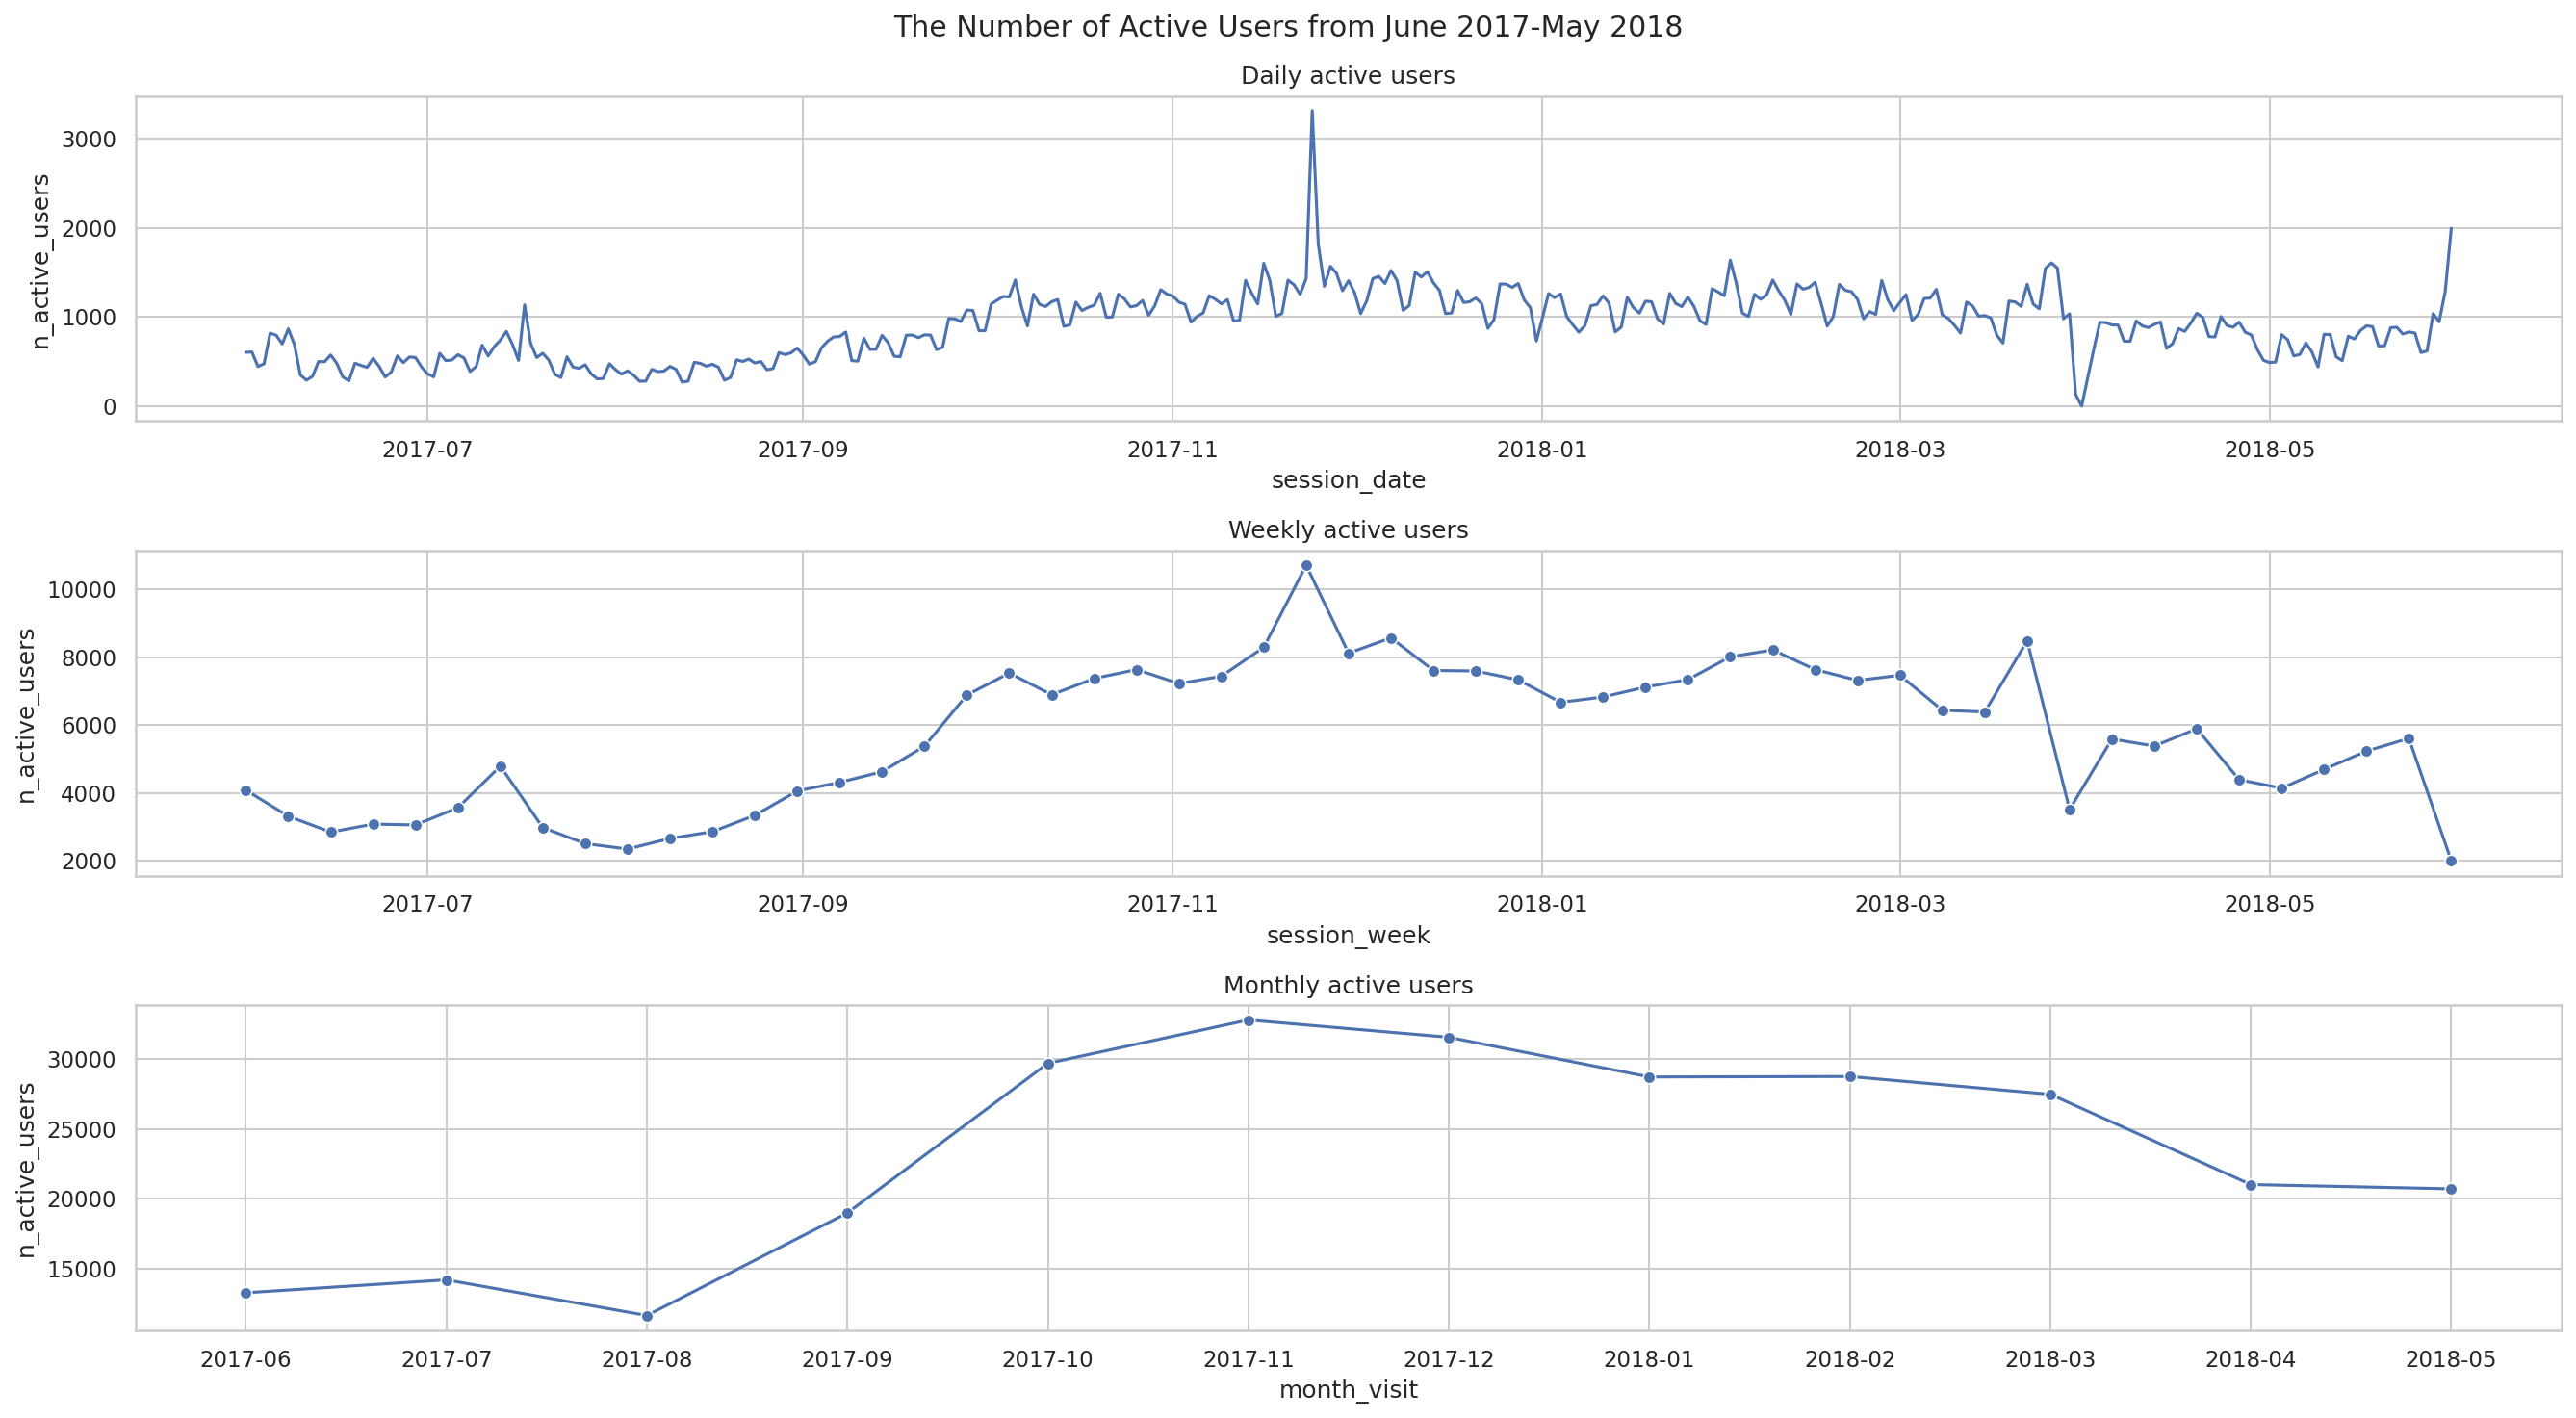

In [46]:
# visualize active users by date, week, and month
sns.set(style='whitegrid')
figure, axes = plt.subplots(3,1, figsize=(18,10), dpi=150)
figure.suptitle('The Number of Active Users from June 2017-May 2018')

#--------------------------------------------------------------------------------------------------------------------------------------------------
# daily active users distribution
(sns.lineplot(ax=axes[0], data=dau, x='session_date', y='n_active_users')
    .set(title='Daily active users')
)
#------------------------------------------------
# weekly active users distribution
(sns.lineplot(ax=axes[1], data=wau, x='session_week', y='n_active_users', marker='o')
    .set(title='Weekly active users')
)
#------------------------------------------------
# monthly active users distribution
(sns.lineplot(ax=axes[2], data=mau, x='month_visit', y='n_active_users', marker='o')
    .set(title='Monthly active users')
)
#------------------------------------------------

plt.tight_layout()
plt.show()

**FINDINGS:**<br>
- The DAU surge happened only one day in December 2017. Mainly, the DAU fluctuates around 907, noticeably
- The WAU and MAU seem to increase significantly starting from Sept 2017, then decreasing slowly after Nov 2018
- The WAUs / MAUs tends to captured new users more than the DAUs in several months, while the DAUs almost remain the same as usual. <br>

**INSIGHTS**<br>
- The findings mean that the users were using the product or service less frequently than others.
<br>WAU and MAU captured new users who may not use the product or service every day, but are still actively engaging with it.
<br> These users may not be captured in the DAU metric if they only started using the product or service recently.
- This suggests that some users only use the platform once a week/month. Align with our previous stickiness calculation.
- In general, having a higher number of WAUs/MAUs than DAUs is not necessarily bad, <br>as the product or service still attracts users and provides value over a more extended period.

**Recommendation**<br>
- Monitoring these metrics over time is essential to ensure that user engagement is consistent and growing. <br> A declining trend in any of these metrics could indicate user retention or satisfaction issues.

*#Note:* The user is considered to be active if there's logging in activity at least once in the particular period


#### Average Session Visit
This section will analyze how many sessions are there in a certain period.<br>
One user might have more than one session.

In [47]:
# group visits_ by daily uid visit
session_day = (visits_clean.groupby('session_date', as_index=False)['uid'].agg(['count','nunique'])
                      .rename(columns={'count':'n_sessions', 'nunique':'n_users'})
              )

session_day['session_per_user'] = session_day['n_sessions'] / session_day['n_users']

# calculate session per day
avg_session_day = session_day['n_sessions'].mean()

# calculate user session per day
avg_user_session_day = session_day['session_per_user'].mean()

print(f'The average session per day : {avg_session_day:.2f}')
print(f'The average user session per day : {avg_user_session_day:.2f}')

The average session per day : 987.36
The average user session per day : 1.08


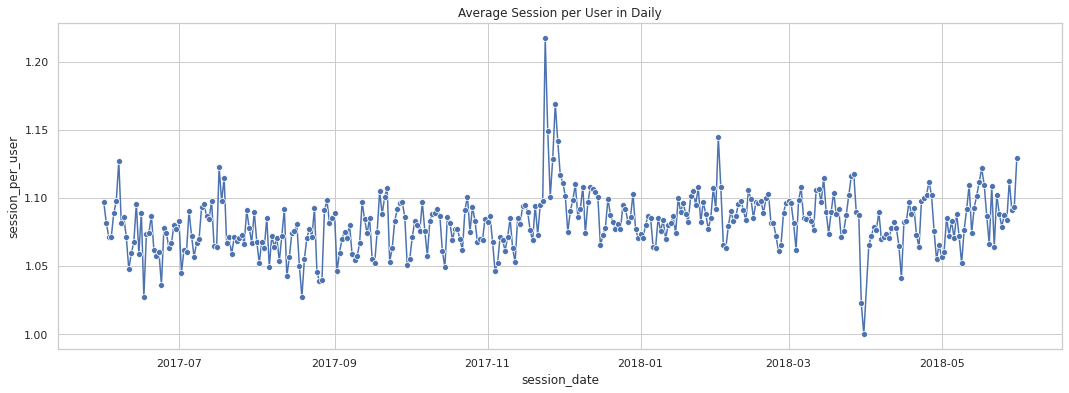

In [48]:
# visualize the user session per day

plt.figure(figsize=(18,6))
(sns.lineplot(data=session_day, x='session_date', y='session_per_user', marker='o')
    .set(title='Average Session per User in Daily')
);

**INSIGHTS:**<br>
- Mainly, the session_per_user(S/U) is around 1.05 - 1.10
- The S/U spiked in early December 2017
- The reduction S/U happened in early April 2018

**RECOMMENDATIONS**<br>
- It's better to check what's happened behind the anomalies (December 2017 and April 2018). We can use similar strategies to attract users and avoid possible actions that might reduce users' interest. 

In [49]:
# group visits_ by monthly uid visit
session_month = (visits_clean
                 .groupby('month_visit')['uid'].agg(['count','nunique'])
                 .rename(columns={'count':'n_sessions', 'nunique':'n_users'})
                 .reset_index()
                )

session_month['session_per_user'] = session_month['n_sessions'] / session_month['n_users']

# calculate user session per month
avg_user_session_month = session_month['session_per_user'].mean()

print(f'The average user session per month : {avg_user_session_month:.0f}')

The average user session per month : 1


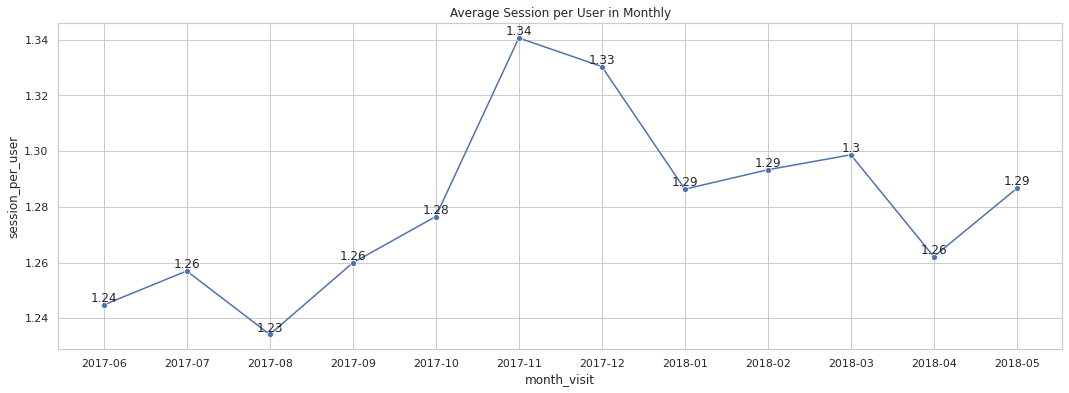

In [50]:
# visualize the user session per month
plt.figure(figsize=(18,6))
(sns.lineplot(data=session_month, x='month_visit', y='session_per_user', marker='o')
    .set(title='Average Session per User in Monthly')
)

# Add annotations
for x, y in zip(session_month['month_visit'], 
                session_month['session_per_user']):
    plt.text(x, y, round(y,2), ha='center', va='bottom', fontdict={'size': 12})

plt.show()

**INSIGHTS:**<br>
- Mostly, users only visit the platform once a day (user's session around 1.23-1.34)
- Even the majority of users only have one session per week or month
- The users use the platform infrequently but are still engaged longer. This might happen since It's common for people to buy entertainment tickets once a week/month. 

#### Average Session Length
Average Session Length (ASL) is the amount of time users spend with a product in the average session.

In [51]:
# calculate session duration
visits_clean['duration'] = (visits_clean['end_ts'] - visits_clean['start_ts']).dt.seconds

# check the percentile
print(np.percentile(visits_clean['duration'], [90,95,99]))

[1620. 2280. 4500.]


<AxesSubplot:xlabel='duration', ylabel='Count'>

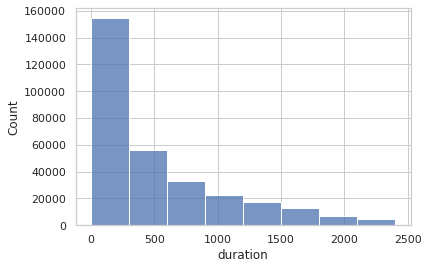

In [52]:
sns.histplot(visits_clean['duration'], binrange=(1,2280), binwidth=300)

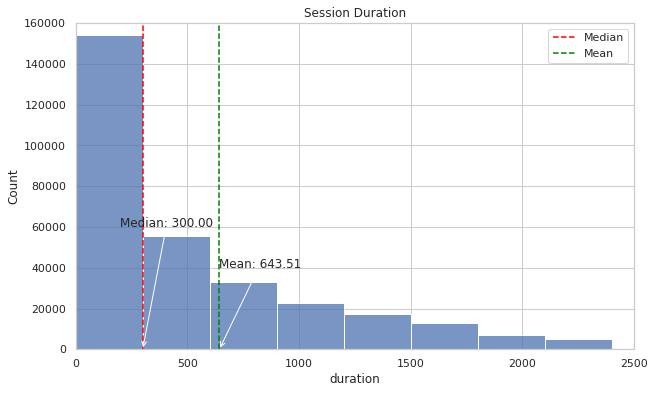

In [53]:
# check distribution of session duration
plt.figure(figsize=(10,6))
plt.title('Session Duration')
ax = sns.histplot(visits_clean['duration'], binrange=(1,2280), binwidth=300)
ax.set(ylim=(0,160000), xlim=(0,2500))

# Calculate the median, mean, and mode
median = np.median(visits_clean['duration'])
mean = np.mean(visits_clean['duration'])


# Add vertical lines for the median, mean, and mode
ax.axvline(median, color='red', linestyle='--', label='Median')
ax.axvline(mean, color='green', linestyle='--', label='Mean')

# Add text annotations for the median, mean, and mode
ax.annotate(f'Median: {median:.2f}', xy=(median, 0), xytext=(median-100, 60000),
            arrowprops=dict(facecolor='red', arrowstyle='->'))
ax.annotate(f'Mean: {mean:.2f}', xy=(mean, 0), xytext=(mean+0, 40000),
            arrowprops=dict(facecolor='green', arrowstyle='->'))

# Add legend
plt.legend()

# Show the plot
plt.show()

**Note:**<br>
- After checking the percentile, we found that 95% of the session durations below 2290 seconds
- The visualization was created by removing 5% outlier so that the bins can be seen clearly

In [54]:
# check mode
visits_clean['duration'].mode()

0    60
dtype: int64

In [55]:
# Check top most session duration
visits_clean['duration'].value_counts(normalize=True, ascending=False)[:5]

60     0.147549
0      0.099594
120    0.099466
180    0.074213
240    0.058667
Name: duration, dtype: float64

**FINDINGS:**<br>
- The distribution of session `duration` is not normal.<br>
- Almost **15%** of users visit for about **60 seconds**, followed by **0sec**(10%), **120sec**(10%), **180sec**(7.4%), **240sec**(6%)
- The mean(643s) and median(300s) are much larger than the mode (60s). It indicates a right-skewed distribution, with most data clustered towards the former.
- Thus, we will use mode as the average duration

**RECOMMENDATIONS**<br>
- We should check why user visits are short (0sec or <60sec).<br>
If the inconvenience of the platform interface, unattractive content, bugs, or other possible problems causes it.

#### Retention Rate

In [56]:
# take relevant data from visits_
# monthly
monthly_user_activity = visits_clean[['uid', 'first_month_visit', 'month_visit', 'lifetime_month']]

In [57]:
## calculate the cohort for each month

cohorts = monthly_user_activity.pivot_table(index='first_month_visit',
                                            columns='lifetime_month',
                                            values='uid',
                                            aggfunc='nunique')


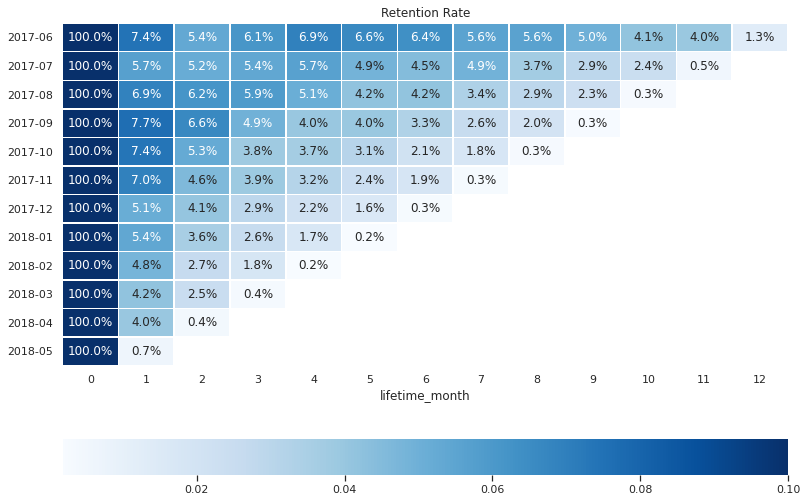

In [58]:
## Retention Rate calculation
retention = pd.DataFrame()    

for col in cohorts.columns:
    retention= pd.concat([retention, cohorts[col]/cohorts[0]], axis=1)

retention.columns = cohorts.columns
retention.index = [str(x)[0:10] for x in retention.index]

## Heat map of the table
plt.figure(figsize=(13, 9))
sns.heatmap(retention,
            annot=True,
            fmt='.1%',
            linewidths=0.5,
            linecolor='white', 
            vmax=0.1,
            cmap='Blues',
            cbar_kws= {'orientation': 'horizontal'} 
           ).set(title = 'Retention Rate')
plt.show()

**FINDINGS:**<br>
- The average retention rate from all cohorts dropped significantly since the first month, then decreased slowly over time
- For the cohort 2017-06, the retention rate slightly increased in a few early months, at the same time as the high retention rate from cohort 2017-08, 2017-09, 2017-10, and 2017-11.

**INSIGHT**<br>
- The marketing activities in Jun, Aug, Sept, Oct, and Nov engages users more. 

**RECOMMENDATIONS:**<br>
- It's better to identify the low retention cause immediately since it happens since the first month (or maybe the first week/first visit), which is the critical period
- It's a common feature for the retention curve to drop off fast at the start.<br>
- However, getting more people to engage early with our product will pull the entire curve upwards.<br>
Thus, we can keep more customers and grow faster.

#### Churn Rate

<div class="alert alert-block alert-info">
<b>Student answer v2</b> <a class="tocSkip"></a>
<br> Please kindly to check my churn rate calculation.<br>
     Thank you
</div>

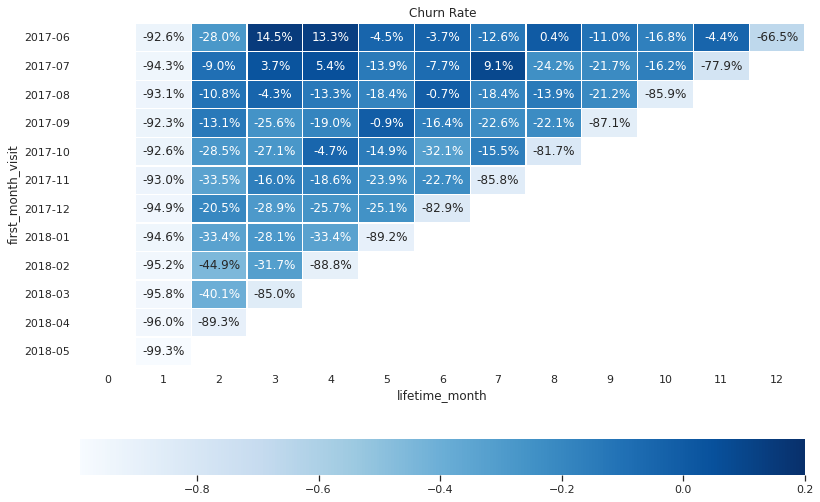

In [59]:
# calculate churn rate based on cohorts
churn = cohorts.pct_change(axis=1).replace({0:np.NaN})

# heatmap visualization
plt.figure(figsize=(13,9))
plt.title('Churn Rate')
sns.heatmap(churn,
            mask=churn.isnull(),
            annot=True,
            linewidth=0.3,
            fmt='.1%',
            linecolor='white',
            cmap='Blues',
            vmax=0.2,
            cbar_kws= {'orientation': 'horizontal'}
           )
plt.show()

**INSIGHT**<br>
- More than 92% of users stop using the platform since the first month
- A high churn rate can signal customer dissatisfaction or a lack of engagement with the product or service.
- Some users from cohort 2017-06 and 2017-07 seemed to return after two months but then left again
- Users from the other cohorts keep stopping using the platform slowly over time
- The marketing activities in Jun, Aug, Sept, Oct, and Nov engaged users more, while the other months did not.


**RECOMMENDATIONS:**<br>
- It's better to take action to reduce the churn rate. It may take measures to improve customer satisfaction, retention, and engagement.

### Sales KPI
- When do people start buying?
- How many orders do they make during a given period of time?
- What is the average purchase size?
- How much money do they bring? (LTV)

#### Conversion Day

For the KPI analysis, we're going to know the time that elapses (days) between **visit** and **conversion** — when the user becomes a customer. <br>
We will use an approach that lets us compare the conversions of different cohorts, so that we can determine which cohort is most effective.

##### Based on Cohort

In [60]:
# retrieve 'first_visit'
first_visit.head()

uid
11863502262781    2018-03-01 17:27:00
49537067089222    2018-02-06 15:55:00
297729379853735   2017-06-07 18:47:00
313578113262317   2017-09-18 22:49:00
325320750514679   2017-09-30 14:29:00
Name: first_visit, dtype: datetime64[ns]

In [61]:
# retrieve 'first_order'
first_order.head()

uid
313578113262317    2018-01-03 21:51:00
1575281904278712   2017-06-03 10:13:00
2429014661409475   2017-10-11 18:33:00
2464366381792757   2018-01-28 15:54:00
2551852515556206   2017-11-24 10:14:00
Name: first_order, dtype: datetime64[ns]

In [62]:
# join 'first_visit' and 'first_order'
# note: not all visits can generate orders, so that the 'first_visit' become main table
first_visit_order = (first_visit.reset_index()
                                .join(first_order, on='uid', how='left')
                                .rename(columns={'buy_ts':'first_order'})
                    )

# check the result
first_visit_order

uid         first_visit         first_order
0             11863502262781 2018-03-01 17:27:00                 NaT
1             49537067089222 2018-02-06 15:55:00                 NaT
2            297729379853735 2017-06-07 18:47:00                 NaT
3            313578113262317 2017-09-18 22:49:00 2018-01-03 21:51:00
4            325320750514679 2017-09-30 14:29:00                 NaT
...                      ...                 ...                 ...
228164  18446403737806311543 2017-11-30 03:36:00                 NaT
228165  18446424184725333426 2017-12-06 20:32:00                 NaT
228166  18446556406699109058 2018-01-01 16:29:00                 NaT
228167  18446621818809592527 2017-12-27 13:27:00                 NaT
228168  18446676030785672386 2017-10-04 16:01:00                 NaT

[228169 rows x 3 columns]

**NOTE:**
- We will not remove NaN values since they will be included in the conversion rate calculation

In [63]:
# find conversion day
# calculate time between first_visits and first order
first_visit_order['conversion_day'] = (first_visit_order['first_order'] - first_visit_order['first_visit']).dt.days

# add first first_month_visit
first_visit_order['first_month_visit'] = (first_visit_order['first_visit'].dt.strftime('%Y-%m'))

# check the result
conversion_day = first_visit_order
conversion_day.head()

uid         first_visit         first_order  conversion_day  \
0   11863502262781 2018-03-01 17:27:00                 NaT             NaN   
1   49537067089222 2018-02-06 15:55:00                 NaT             NaN   
2  297729379853735 2017-06-07 18:47:00                 NaT             NaN   
3  313578113262317 2017-09-18 22:49:00 2018-01-03 21:51:00           106.0   
4  325320750514679 2017-09-30 14:29:00                 NaT             NaN   

  first_month_visit  
0           2018-03  
1           2018-02  
2           2017-06  
3           2017-09  
4           2017-09

In [64]:
# group conversion day by cohort
top_conversion_day_cohort = conversion_day.groupby('first_month_visit')['conversion_day'].value_counts(dropna=False)

# chooce top 5 conversion day
top_conversion_day_cohort = top_conversion_day_cohort.groupby('first_month_visit').head(5).reset_index(name='n_users')

# replace NaN
top_conversion_day_cohort['conversion_day'].fillna('No Order', inplace=True)

# check the result
top_conversion_day_cohort.head(10)

first_month_visit conversion_day  n_users
0           2017-06       No Order    10336
1           2017-06            0.0     1804
2           2017-06            1.0       55
3           2017-06            3.0       34
4           2017-06            2.0       27
5           2017-07       No Order    10682
6           2017-07            0.0     1526
7           2017-07            1.0       59
8           2017-07            2.0       37
9           2017-07            4.0       20

In [65]:
# check the rows
len(top_conversion_day_cohort)

60

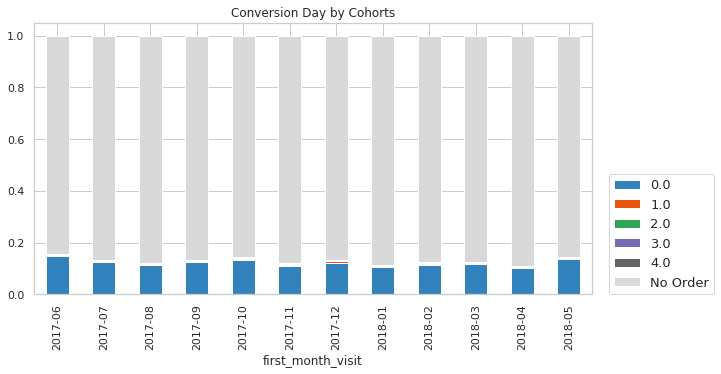

In [66]:
# build crosstab table
crosstab_conversion_cohort = pd.crosstab(index=top_conversion_day_cohort['first_month_visit'],
                                         columns=top_conversion_day_cohort['conversion_day'],
                                         values=top_conversion_day_cohort['n_users'],
                                         aggfunc='sum',
                                         normalize='index')

# plot the crosstab table
(crosstab_conversion_cohort.plot(kind='bar', stacked=True, colormap='tab20c',
                                 figsize=(10, 5), title='Conversion Day by Cohorts')
                           .legend(loc=(1.03, 0), fontsize=13)
)
plt.show()

In [67]:
# check overall conversion day by users ratio
conversion_day['conversion_day'].value_counts(ascending=False, normalize=True, dropna=False)[:5]

NaN    0.839934
0.0    0.115537
1.0    0.004431
2.0    0.002467
3.0    0.001902
4.0    0.001420
5.0    0.001183
Name: conversion_day, dtype: float64

**FINDINGS:**<br>
- Mostly, new users will make orders in 0day (11%)
- The conversion day will rarely happen for the next day or even the after
- More than 80% of users in all cohorts didn't make orders
- All cohorts' conversion rate proportion for 0 days is almost similar.

**INSIGHTS:**<br>
- It seems like the service can successfully attract new users to make an order immediately (0day)
- We can say the conversion rate (>10%) is quite high, but it would be better to escalate this number

In [68]:
# initialize 'conversion_day' by cohort monthly
conversion_cohorts = (conversion_day.groupby('first_month_visit')['conversion_day']
                                        .agg(['min', 'max', 'mean', 'median', pd.Series.mode])
                                        .reset_index()
                        )

# check the result
conversion_cohorts

first_month_visit  min    max       mean  median  mode
0            2017-06  0.0  363.0  46.409853     0.0   0.0
1            2017-07  0.0  331.0  40.220098     0.0   0.0
2            2017-08  0.0  298.0  33.194073     0.0   0.0
3            2017-09  0.0  268.0  24.737083     0.0   0.0
4            2017-10  0.0  241.0  16.851005     0.0   0.0
5            2017-11  0.0  208.0  15.463163     0.0   0.0
6            2017-12  0.0  179.0  10.636721     0.0   0.0
7            2018-01  0.0  143.0   8.211286     0.0   0.0
8            2018-02  0.0  117.0   5.199309     0.0   0.0
9            2018-03  0.0   86.0   2.937984     0.0   0.0
10           2018-04  0.0   54.0   2.083598     0.0   0.0
11           2018-05  0.0   26.0   0.525270     0.0   0.0

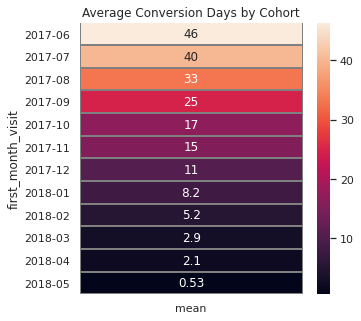

In [69]:
# create pivot table and display in heatmap
conversion_report = conversion_cohorts.pivot_table(index='first_month_visit',
                                                         values='mean',
                                                         aggfunc='mean')
# display heatmap
sns.set(style='white')
plt.figure(figsize=(5,5))
plt.title('Average Conversion Days by Cohort')
sns.heatmap(conversion_report, annot=True, linecolor='gray', linewidths=1);

**FINDINGS:**<br>
- The average conversion day in each cohort decreases over time

**INSIGHTS:**<BR>
- At a glance, we thought that the service performance seemed to be more reliable since the average conversion day became faster 
- However, this might indicate two possibilities, whether the service successfully hits the target market so that the new users can decide faster, or it's no longer attractive to make a new user think twice about making an order through this platform.
    
**RECOMMENDATIONS:**<br>
- We can investigate the reason behind this number, whether this indicates a good thing or not.

##### Based on Source

This section will compare the conversions day in different marketing channel, so that we can determine marketing channel is most effective

In [70]:
# retrieve 'conversion_day' dataset
conversion_day.head()

uid         first_visit         first_order  conversion_day  \
0   11863502262781 2018-03-01 17:27:00                 NaT             NaN   
1   49537067089222 2018-02-06 15:55:00                 NaT             NaN   
2  297729379853735 2017-06-07 18:47:00                 NaT             NaN   
3  313578113262317 2017-09-18 22:49:00 2018-01-03 21:51:00           106.0   
4  325320750514679 2017-09-30 14:29:00                 NaT             NaN   

  first_month_visit  
0           2018-03  
1           2018-02  
2           2017-06  
3           2017-09  
4           2017-09

In [71]:
# check rows 
len(conversion_day)

228169

In [72]:
# retrive 'orders_clean' dataset
orders_clean.head()

buy_ts  revenue                   uid order_month  source_id
0 2017-06-01 00:10:00    17.00  10329302124590727494  2017-06-01          1
1 2017-06-01 00:25:00     0.55  11627257723692907447  2017-06-01          2
2 2017-06-01 00:27:00     0.37  17903680561304213844  2017-06-01          2
3 2017-06-01 00:29:00     0.55  16109239769442553005  2017-06-01          2
4 2017-06-01 07:58:00     0.37  14200605875248379450  2017-06-01          3

In [73]:
# check rows 
len(orders_clean)

50414

In [74]:
# modified `conversion_day`
# drop NaN columns, since we will not calculate conversion rate
# add source_id by merging with `new_orders`

conversion_day_sources = (conversion_day
                          .merge(orders_clean, how='left', left_on=['uid', 'first_order'], right_on=['uid','buy_ts'])
                         )

# check the result
conversion_day_sources

uid         first_visit         first_order  \
0             11863502262781 2018-03-01 17:27:00                 NaT   
1             49537067089222 2018-02-06 15:55:00                 NaT   
2            297729379853735 2017-06-07 18:47:00                 NaT   
3            313578113262317 2017-09-18 22:49:00 2018-01-03 21:51:00   
4            325320750514679 2017-09-30 14:29:00                 NaT   
...                      ...                 ...                 ...   
228164  18446403737806311543 2017-11-30 03:36:00                 NaT   
228165  18446424184725333426 2017-12-06 20:32:00                 NaT   
228166  18446556406699109058 2018-01-01 16:29:00                 NaT   
228167  18446621818809592527 2017-12-27 13:27:00                 NaT   
228168  18446676030785672386 2017-10-04 16:01:00                 NaT   

        conversion_day first_month_visit              buy_ts  revenue  \
0                  NaN           2018-03                 NaT      NaN   
1                  NaN           2018-02                 NaT      NaN   
2                  NaN           2017-06                 NaT      NaN   
3                106.0           2017-09 2018-01-03 21:51:00     0.55   
4                  NaN           2017-09                 NaT      NaN   
...                ...               ...                 ...      ...   
228164             NaN           2017-11                 NaT      NaN   
228165             NaN           2017-12                 NaT      NaN   
228166             NaN           2018-01                 NaT      NaN   
228167             NaN           2017-12                 NaT      NaN   
228168             NaN           2017-10                 NaT      NaN   

       order_month  source_id  
0              NaT        NaN  
1              NaT        NaN  
2              NaT        NaN  
3       2018-01-01        4.0  
4              NaT        NaN  
...            ...        ...  
228164         NaT        NaN  
228165         NaT        NaN  
228166         NaT        NaN  
228167         NaT        NaN  
228168         NaT        NaN  

[228169 rows x 9 columns]

In [75]:
# modified dataset
# count the conversion day from each source
coversion_sources_report = (
    conversion_day_sources
    .groupby('source_id')
    .agg({'uid':'nunique', 'conversion_day':['mean', pd.Series.mode, 'max']})
    .reset_index()
    .rename(columns={'nunique':'buyers', '':'source_id'})
)

coversion_sources_report.columns = coversion_sources_report.columns.droplevel(0)
coversion_sources_report['source_id'] = coversion_sources_report['source_id'].astype('int')

coversion_sources_report

source_id  buyers       mean  mode    max
0          1    4770  18.275262   0.0  355.0
1          2    4076  24.086114   0.0  352.0
2          3    8759  14.397077   0.0  363.0
3          4    9381  15.830722   0.0  362.0
4          5    7497  14.834467   0.0  354.0
5          7       1   0.000000   0.0    0.0
6          9     764  27.886126   0.0  316.0
7         10    1274  14.557300   0.0  357.0

In [76]:
# validate the result
# `uid` from `orders_` = total `buyers` from `coversion_sources_report`
orders_clean['uid'].nunique() == coversion_sources_report['buyers'].sum()

True

In [77]:
# calculate number of new_users from every marketing channel
new_users_sources = (
    visits_clean['source_id']
    .value_counts()
    .reset_index()
    .rename(columns={'source_id':'new_users'})
)
new_users_sources

index  new_users
0      4     101794
1      3      85610
2      5      66905
3      2      47626
4      1      34121
5      9      13277
6     10      10025
7      7         36
8      6          6

In [78]:
# merge data
coversion_sources_report = (
    coversion_sources_report
    .merge(new_users_sources, how='left', left_on='source_id', right_on='index')
    .drop(columns=['index'])
    .assign(conversion_rate=lambda df : df['buyers']/df['new_users'])
)

# calculate conversion rate
coversion_day_source_ = coversion_sources_report.sort_values(by=['conversion_rate'], ascending=False)

# rename columns
coversion_day_source_.rename(columns={'mean':'conversion_day_mean',
                                         'mode':'conversion_day_mode',
                                         'max':'conversion_day_max'}, inplace=True)
# check the result
coversion_day_source_

source_id  buyers  conversion_day_mean  conversion_day_mode  \
0          1    4770            18.275262                  0.0   
7         10    1274            14.557300                  0.0   
4          5    7497            14.834467                  0.0   
2          3    8759            14.397077                  0.0   
3          4    9381            15.830722                  0.0   
1          2    4076            24.086114                  0.0   
6          9     764            27.886126                  0.0   
5          7       1             0.000000                  0.0   

   conversion_day_max  new_users  conversion_rate  
0               355.0      34121         0.139797  
7               357.0      10025         0.127082  
4               354.0      66905         0.112054  
2               363.0      85610         0.102313  
3               362.0     101794         0.092157  
1               352.0      47626         0.085584  
6               316.0      13277         0.057543  
5                 0.0         36         0.027778

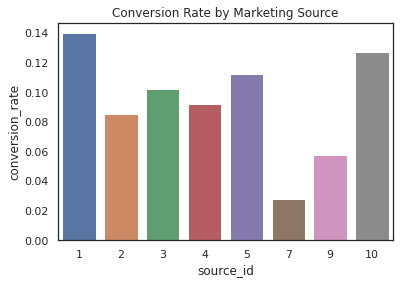

In [79]:
# visualize conversion rate by cohort
plt.figure(figsize=(6,4))
plt.title('Conversion Rate by Marketing Source')
sns.barplot(data=coversion_day_source_, x='source_id', y='conversion_rate');

**FINDINGS:**<br>
- All the marketing channels mostly have conversion day = 0 day
- However, the average conversion day of all marketing channels vary
- Sources 9 and 2 have long average conversion days, which are around 27-28 days (9) and 24 days (2)
- The conversion rate from source_id 1 and 10 were high
- The marketing channel that brings lots of customers come from source 4 and 3

**INSIGHTS:**<BR>
- We can assess the impact of all source marketing by proportional assessment from conversion rate, total customers gained, and conversion day period, then compare it with the cost
    
**RECOMMENDATIONS:**<br>
- It is better to allocate the most ineffective marketing channel (in this case, 7 and 9) to the highly effective one

#### Number of Order per Customer

This section will analyze the average number of order per customer from each cohort.<br> 
**Customer** refers to the **buyer** or users who make order.

In [80]:
# STEP 1 : 
# create `orders_cohorts`
# Aggregate orders data from all cohorts monthly
# -----------------------------------------------------------------------------------
## retrieve and modify data from `first_order`
first_orders = first_order.reset_index()
first_orders['first_order_month'] = first_orders['first_order'].astype('datetime64[M]')


## retrieve and take relevant data from `orders_clean`
orders_ = orders_clean[['buy_ts', 'revenue', 'uid', 'order_month']]

#-------------------------------------------------------------------------------------
## build and define order cohorts

### merge `orders_` and `first_orders`
### we will enrich the `orders` dataset with column `first_order_month`, 
#### initialize the cohort by `first_order_month`
### and count the number of orders in every cohort in certain period

order_cohorts = (orders_
                 .merge(first_orders, on='uid')
                 .groupby(['first_order_month', 'order_month'])
                 .agg({'buy_ts':'count', 'uid':'nunique', 'revenue':'sum'})
                 .reset_index()
                 .rename(columns={'buy_ts':'n_orders', 'uid':'n_customers'})
                )


# check the result
order_cohorts

first_order_month order_month  n_orders  n_customers   revenue
0         2017-06-01  2017-06-01      2354         2023   9557.49
1         2017-06-01  2017-07-01       177           61    981.82
2         2017-06-01  2017-08-01       174           50    885.34
3         2017-06-01  2017-09-01       226           54   1931.30
4         2017-06-01  2017-10-01       292           88   2068.58
..               ...         ...       ...          ...       ...
73        2018-03-01  2018-04-01       178           90   1063.05
74        2018-03-01  2018-05-01       176           58   1114.87
75        2018-04-01  2018-04-01      2495         2276  10600.69
76        2018-04-01  2018-05-01       195           69   1209.92
77        2018-05-01  2018-05-01      3249         2988  13925.76

[78 rows x 5 columns]

In [81]:
# validate the result
## the total number of orders in all cohorts should be equal to
## the number of orders in the main dataset ('orders_clean')

print('check number of orders:', order_cohorts['n_orders'].sum() == len(orders_clean))

## The sum of revenue should be equal for both dataset
print('check total revenue:', order_cohorts['revenue'].sum() == orders_clean['revenue'].sum())
print('check the different of both revenues:', order_cohorts['revenue'].sum(), 'vs', orders_clean['revenue'].sum())

check number of orders: True
check total revenue: False
check the different of both revenues: 252053.77999999933 vs 252053.77999999997


**Note:** The modified table has the same total value as the raw data. No double counting ✅ 

In [82]:
# STEP 2
## create `cohort_sizes_`
## get the number of initial buyers from each cohort

cohort_sizes_ = (first_orders
                 .groupby('first_order_month')
                 .agg({'uid':'nunique'})
                 .reset_index()
                 .rename(columns={'uid':'initial_customers'})
                 )
cohort_sizes_

first_order_month  initial_customers
0         2017-06-01               2023
1         2017-07-01               1923
2         2017-08-01               1370
3         2017-09-01               2581
4         2017-10-01               4340
5         2017-11-01               4081
6         2017-12-01               4383
7         2018-01-01               3373
8         2018-02-01               3651
9         2018-03-01               3533
10        2018-04-01               2276
11        2018-05-01               2988

In [83]:
# validate the results
## toatl amount of initial customers from all cohorts should equal to
## unique `uid` from `orders_clean`

cohort_sizes_['initial_customers'].sum() == orders_clean['uid'].nunique()

True

In [84]:
# STEP 3
## Aggregate `order_cohorts` and `cohort_sizes`

order_cohorts_report = (order_cohorts
                        .merge(cohort_sizes_, on='first_order_month')
                       )

# step 4
## calculate the age_month
order_cohorts_report['age_month'] = (((order_cohorts_report['order_month']
                                     -order_cohorts_report['first_order_month'])
                                     / np.timedelta64(1, 'M'))
                                     .round()
                                     .astype(int)
                                    )

## calculate the order/buyer
order_cohorts_report['avg_n_order/cust'] = order_cohorts_report['n_orders']/order_cohorts_report['n_customers']

# datetime adjustment
order_cohorts_report['first_order_month_'] = order_cohorts_report['first_order_month'].dt.strftime('%Y-%m')

order_cohorts_report

first_order_month order_month  n_orders  n_customers   revenue  \
0         2017-06-01  2017-06-01      2354         2023   9557.49   
1         2017-06-01  2017-07-01       177           61    981.82   
2         2017-06-01  2017-08-01       174           50    885.34   
3         2017-06-01  2017-09-01       226           54   1931.30   
4         2017-06-01  2017-10-01       292           88   2068.58   
..               ...         ...       ...          ...       ...   
73        2018-03-01  2018-04-01       178           90   1063.05   
74        2018-03-01  2018-05-01       176           58   1114.87   
75        2018-04-01  2018-04-01      2495         2276  10600.69   
76        2018-04-01  2018-05-01       195           69   1209.92   
77        2018-05-01  2018-05-01      3249         2988  13925.76   

    initial_customers  age_month  avg_n_order/cust first_order_month_  
0                2023          0          1.163618            2017-06  
1                2023          1          2.901639            2017-06  
2                2023          2          3.480000            2017-06  
3                2023          3          4.185185            2017-06  
4                2023          4          3.318182            2017-06  
..                ...        ...               ...                ...  
73               3533          1          1.977778            2018-03  
74               3533          2          3.034483            2018-03  
75               2276          0          1.096221            2018-04  
76               2276          1          2.826087            2018-04  
77               2988          0          1.087349            2018-05  

[78 rows x 9 columns]

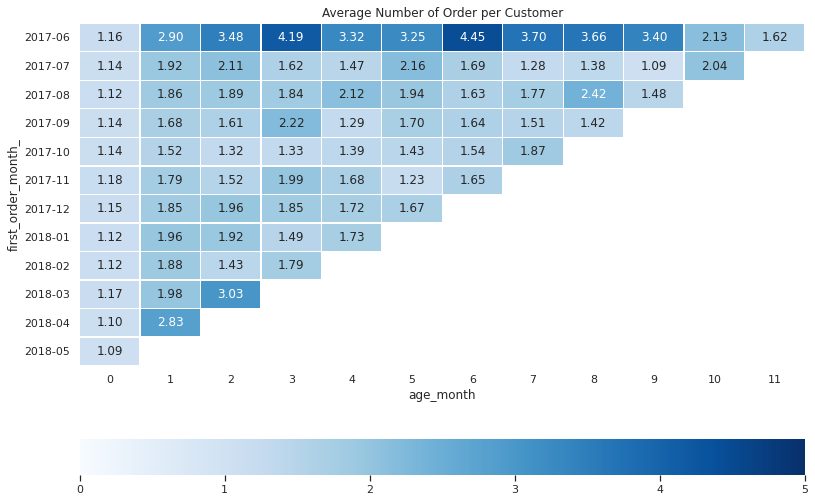

In [85]:
# visualize the average number of order per customer

## create pivot table
n_order_per_cust = order_cohorts_report.pivot_table(index='first_order_month_',
                                                    columns='age_month',
                                                    values='avg_n_order/cust'
                                                   )

## heatmap visualization
plt.figure(figsize=(13,9))
plt.title('Average Number of Order per Customer')
sns.heatmap(n_order_per_cust,
            annot=True,
            linewidth=0.3,
            fmt='.2f',
            vmin=0,
            vmax=5,
            linecolor='white',
            cmap='Blues',
            cbar_kws= {'orientation': 'horizontal'}
           )
plt.show()

In [86]:
# check the average number of order per customer based on the `age_month`
avg_n_order_per_cust = n_order_per_cust.mean(axis=0)
avg_n_order_per_cust

age_month
0     1.135603
1     2.016674
2     2.025814
3     2.034730
4     1.840059
5     1.911234
6     2.099438
7     2.027218
8     2.218946
9     1.991593
10    2.085897
11    1.622642
dtype: float64

In [87]:
# the average number of order per customer
avg_n_order_per_cust.mean().round(2)

1.92

**FINDINGS:**<br>
- From heatmap visualization, only users in cohort 2017-06 that tend to have more than 2-3 orders over time
- The majority of users from all cohorts order only 1-2 over time

**INSIGHTS:**<br>
- Over time, the number of order per customer in almost all cohort remain the same (1-2).
- This may indicate several possibilities, such as :
    1. Customer behavior is consistent. <br>
    It could mean that customers have a consistent purchasing pattern and stay the same buying habits over time. This could be a positive sign, indicating customer loyalty and satisfaction with the product or service.
    2. Market saturation
    3. Lack of upselling opportunities
    4. Competitive pressures. 
    <br>If the number of orders per customer remains the same while competitors are growing their business, it could mean that customers are shifting their loyalty to the competition. 
    
**RECOMMENDATIONS:**<br>
Here're some recommendations based on the cause:
1. Lack of upselling opportunities: Understanding your customers' needs, training your staff, bundling products or services, providing incentives, and personalizing recommendations
2. Market saturation: Explore new markets or develop new products to increase revenue
3. Competitive pressures: Businesses may need to assess the competition and change their product, pricing, or marketing strategies to stay competitive.



#### Purchase Size

Purchase Size is the average amount of products purchased by one buying user. Here, we will identify the average revenue that one user can bring on an order.

In [90]:
# calculate purchase_size
# use dataset from previous section: `order_cohorts_report`
order_cohorts_report['purchase_size'] = order_cohorts_report['revenue']/order_cohorts_report['n_orders']
order_cohorts_report.head()

first_order_month order_month  n_orders  n_customers  revenue  \
0        2017-06-01  2017-06-01      2354         2023  9557.49   
1        2017-06-01  2017-07-01       177           61   981.82   
2        2017-06-01  2017-08-01       174           50   885.34   
3        2017-06-01  2017-09-01       226           54  1931.30   
4        2017-06-01  2017-10-01       292           88  2068.58   

   initial_customers  age_month  avg_n_order/cust first_order_month_  \
0               2023          0          1.163618            2017-06   
1               2023          1          2.901639            2017-06   
2               2023          2          3.480000            2017-06   
3               2023          3          4.185185            2017-06   
4               2023          4          3.318182            2017-06   

   purchase_size  
0       4.060106  
1       5.547006  
2       5.088161  
3       8.545575  
4       7.084178

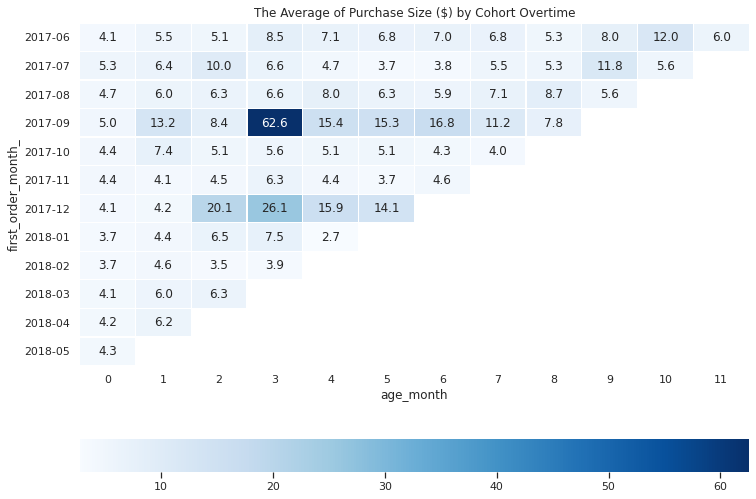

In [91]:
# visualize purchase size cohort through pivot table and heatmap
purchase_size_cohort = (order_cohorts_report
                        .pivot_table(index='first_order_month_',
                           columns='age_month',
                           values='purchase_size',
                           aggfunc='mean'
                           )
             ) 

plt.figure(figsize=(12,9))
plt.title('The Average of Purchase Size ($) by Cohort Overtime')
sns.heatmap(purchase_size_cohort,
            annot=True,
            cmap='Blues',
            linecolor='white',
            linewidths=0.3,
            fmt='.1f',
            cbar_kws= {'orientation': 'horizontal'}
           );

In [92]:
# calculate the average purchase size
purchase_size_cohort.mean(axis=0)

age_month
0      4.329499
1      6.189028
2      7.563060
3     14.858098
4      7.924951
5      7.854482
6      7.048592
7      6.909111
8      6.778275
9      8.466116
10     8.843213
11     6.042093
dtype: float64

**FINDINGS:**<br>
- Mostly, the average purchase size from each cohort is around 4-8. This is equivalent to the price of 1-2 movie tickets in Russia
- Anomalies were detected on:
1. Cohort 2017-09 in age three months. Perhaps, a significant event (e.g., a concert, etc.) at that time could boost the purchase size. Then, It gave after effect by pulling the avg purchase size, so It's higher than other cohorts
2. Users from cohort 2017 experience the same phenomenon but with a lower purchase size

**INSIGHTS:**<BR>
- It seems that the right offering can boost purchase size and may give the pull effect after that
- In all cohorts, the repeated orders yielded higher purchase size over time

#### Lifetime Value (LTV)

To calculate LTV, we need the gross profit margin of Yandex Afisha from June 2017 to May 2018. However, we will use the `revenue` for this case since the profit is not readily available.

In [93]:
# calculate ltv
order_cohorts_report['ltv'] = order_cohorts_report['revenue']/order_cohorts_report['initial_customers']

# check the result
order_cohorts_report.head()

first_order_month order_month  n_orders  n_customers  revenue  \
0        2017-06-01  2017-06-01      2354         2023  9557.49   
1        2017-06-01  2017-07-01       177           61   981.82   
2        2017-06-01  2017-08-01       174           50   885.34   
3        2017-06-01  2017-09-01       226           54  1931.30   
4        2017-06-01  2017-10-01       292           88  2068.58   

   initial_customers  age_month  avg_n_order/cust first_order_month_  \
0               2023          0          1.163618            2017-06   
1               2023          1          2.901639            2017-06   
2               2023          2          3.480000            2017-06   
3               2023          3          4.185185            2017-06   
4               2023          4          3.318182            2017-06   

   purchase_size       ltv  
0       4.060106  4.724414  
1       5.547006  0.485329  
2       5.088161  0.437637  
3       8.545575  0.954671  
4       7.084178  1.022531

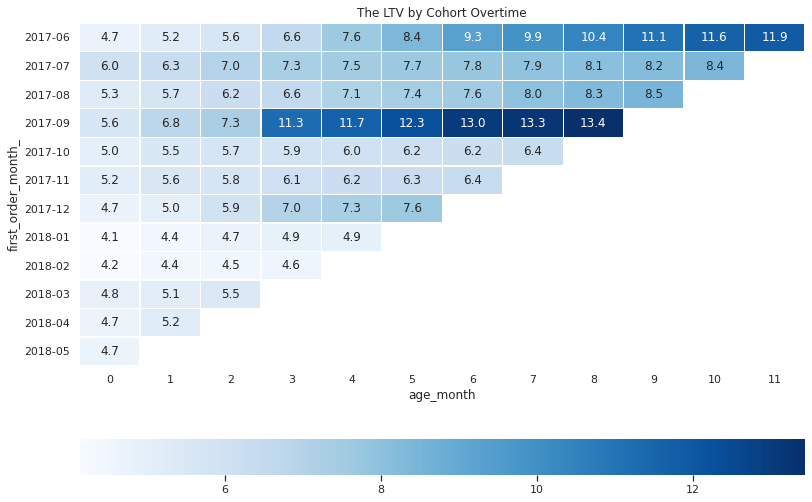

In [94]:
# visualize ltv cohort through pivot table and heatmap
ltv_cohort = (order_cohorts_report
              .pivot_table(index='first_order_month_',
                           columns='age_month',
                           values='ltv',
                           aggfunc='sum'
                           )
             ).cumsum(axis=1)

plt.figure(figsize=(13,9))
plt.title('The LTV by Cohort Overtime')
sns.heatmap(ltv_cohort,
            annot=True,
            cmap='Blues',
            linecolor='white',
            linewidths=0.3,
            fmt='.1f',
            cbar_kws= {'orientation': 'horizontal'}
           );

In [95]:
# calculate the average cumulative lTV by lifetime
ltv_cohort.mean(axis=0)

age_month
0      4.916823
1      5.395666
2      5.821811
3      6.689763
4      7.298634
5      7.969053
6      8.387686
7      9.083583
8     10.062084
9      9.251340
10    10.004616
11    11.879234
dtype: float64

**INSIGHT:**<br>
- The average LTV for all cohorts in one year is 11.88 USD. <br>
It means each customer will bring a gross profit of around 11.88 USD
- Cohort from 2017 tends to bring higher LTV than from cohort from 2018. The marketing activities in the second term of 2017 are more successful than in the first term of 2018.
- There are surges in cohorts 2017-09 and 2017-12 (3,4,5 months old). <br>
The normal condition (w/o surge) will probably result in LTV below 11.881 USD

### Marketing
- How much money was spent? Overall/per source/over time
- How much did customer acquisition from each of the sources cost?
- How worthwhile where the investments? (ROMI)

Plot graphs to display how these metrics differ for various ad sources and how they change in time.

#### Marketing Cost

This section will calculate the marketing cost in one year and monthly, both total and based on marketing channel.

In [96]:
# retrive costs
costs.sample(5)

source_id         dt   costs
2480         10 2018-03-29   20.88
302           1 2018-03-30    6.98
909           3 2017-12-01  452.52
1201          4 2017-09-21   95.94
1764          5 2018-04-10  116.01

##### One Year Cost

In [97]:
# calculate overall marketing cost
print('Total marketing expenses (June 2017 - May 2018):',
      costs['costs'].sum()
     )

Total marketing expenses (June 2017 - May 2018): 329131.62


##### Monthly Cost

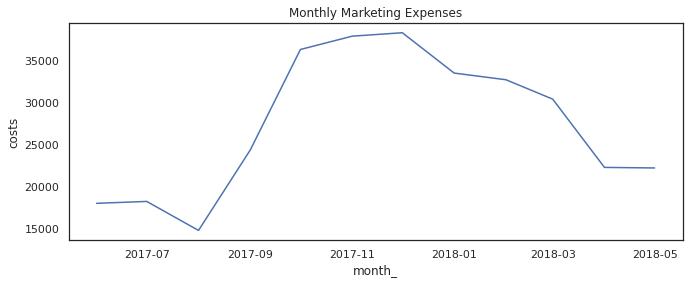

In [98]:
# retrieve `costs` dataset
# add 'month_' in `costs`
costs['month_'] = costs['dt'].astype('datetime64[M]')

# calculate marketing cost by month
monthly_costs = costs.groupby(['month_'])['costs'].sum().reset_index()

# visualize marketing expense by month
plt.figure(figsize=(11,4))
plt.title('Monthly Marketing Expenses')
sns.lineplot(data=monthly_costs, x='month_', y='costs');

##### Marketing Channel Cost

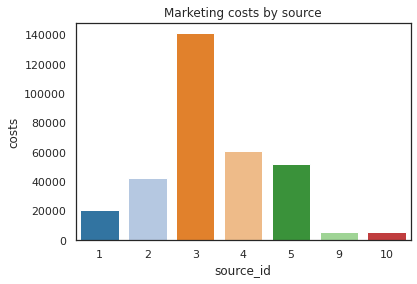

In [99]:
# calculate and visualize marketing cost by source in one year
costs_source = costs.groupby('source_id')['costs'].sum().reset_index()

plt.figure(figsize=(6,4))
plt.title('Marketing costs by source')
sns.barplot(data=costs_source, x='source_id', y='costs', palette='tab20');

In [100]:
# group monthly based on `source_id`
cost_source_month = (
    costs.groupby(['source_id','month_'])['costs'].sum().reset_index()
)

cost_source_month

source_id     month_    costs
0           1 2017-06-01  1125.61
1           1 2017-07-01  1072.88
2           1 2017-08-01   951.81
3           1 2017-09-01  1502.01
4           1 2017-10-01  2315.75
..        ...        ...      ...
79         10 2018-01-01   614.35
80         10 2018-02-01   480.88
81         10 2018-03-01   526.41
82         10 2018-04-01   388.25
83         10 2018-05-01   409.86

[84 rows x 3 columns]

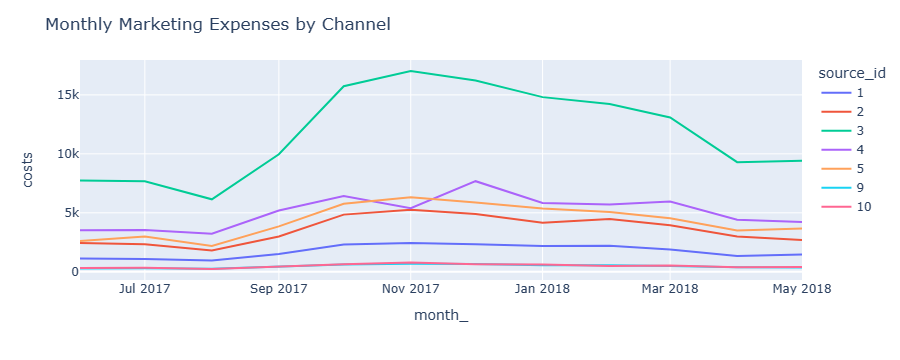

In [101]:
# visualize monthly marketing expense by source_id
(px
 .line(cost_source_month, x='month_', y='costs', color='source_id')
 .update_layout(title='Monthly Marketing Expenses by Channel')
 .show()
)

In [102]:
# compare channel cost vs conversion rate
# retrieve conversion rate based on source_id
conversion_rate = (
    coversion_day_source_[['source_id', 'new_users', 'buyers', 'conversion_rate']]
    .merge(costs_source, on='source_id', how='left')
    .sort_values('buyers', ascending=False)
    .reset_index(drop=True)
    [:7]
)

conversion_rate

source_id  new_users  buyers  conversion_rate      costs
0          4     101794    9381         0.092157   61073.60
1          3      85610    8759         0.102313  141321.63
2          5      66905    7497         0.112054   51757.10
3          1      34121    4770         0.139797   20833.27
4          2      47626    4076         0.085584   42806.04
5         10      10025    1274         0.127082    5822.49
6          9      13277     764         0.057543    5517.49

##### Insight

**FINDINGS:**<br>
- During 2017-06 - 2018-05, the total marketing cost is 329131.62 USD
- The marketing cost increased from 2017-09, then decreased gradually
- The curve from `monthly_marketing_cost` aligns with the curve from `monthly_user_actives.`
- In one year, the majority of marketing cost was allocated to `source_id` 3, followed by `source_id` 5 and 5 
- From the `conversion_rate` table, we found that:
    - several marketing channels effectively attract more customers at lower cost
    - `source_id` 4 attracts more than 7% of customers with a 2.3x cheaper cost than `source_id` 3
    - `source_id` 1 attracts more than 17% of customers with 2x cheaper cost than `source_id` 2

**INSIGHTS:**<BR>
- Several marketing channels (especially 3 and 2) seem to be more inefficient and ineffective than the others (4 and 1)
- The marketing cost indeed aligns with the number of new users gained
    
**RECOMMENDATIONS:**<br>
- It's advisable to reallocate the marketing cost to the marketing channel that costs lower but is more effective

#### CAC and ROMI

This section will analyze how worthwhile the marketing cost is. We will calculate the Customer Acquisition Cost (CAC) and identify when the marketing investment will recoup or generate profit.

After that, we will calculate the Return on Marketing Investment (ROMI) based on the cohort. <br>
We will analyze how worth the marketing expenses are to the incremental revenue. <br>
By dividing the LTV/CAC, we will get the ROMI. 

In [103]:
#calculate the mean CAC from overall dataset
print("Mean CAC is:", round(costs['costs'].sum() / orders['uid'].nunique(), 2))

Mean CAC is: 9.01


##### Based on Cohort

**Calculate CAC (Customer Acquisition Cost)**

In [104]:
# CAC metrics by month (cohort)

# -----------------------------------------------------------------------------------------
## merging `cohort_sizes_` and `costs`
### CAC by month
cac_cohort_month = pd.merge(costs.groupby('month_').agg({'costs': 'sum'}), 
                            cohort_sizes_,
                            left_on='month_', 
                            right_on='first_order_month')

# -----------------------------------------------------------------------------------------
### calculate cac
cac_cohort_month['cac'] = cac_cohort_month['costs']/cac_cohort_month['initial_customers']

### check the result
cac_cohort_month.head(3)

costs first_order_month  initial_customers        cac
0  18015.00        2017-06-01               2023   8.905091
1  18240.59        2017-07-01               1923   9.485486
2  14790.54        2017-08-01               1370  10.796015

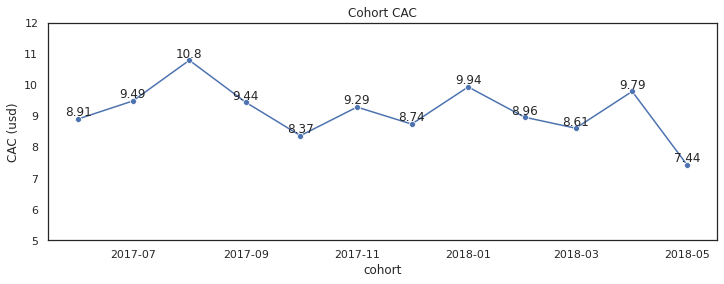

In [105]:
# plot `cac_cohort_month`
plt.figure(figsize=(12,4))
(sns.lineplot(data=cac_cohort_month,
              x='first_order_month', y='cac', marker='o'     
           ).set(ylim=(5,12), title='Cohort CAC', xlabel='cohort', ylabel='CAC (usd)')
)

# Add annotations
for x, y in zip(cac_cohort_month['first_order_month'], 
                cac_cohort_month['cac']):
    plt.text(x, y, round(y,2), ha='center', va='bottom', fontdict={'size': 12})

plt.show()

**Calculate ROMI (Return-on-Marketing-Investment)**

In [106]:
# CALCULATE ROMI FROM EACH COHORT
## use relevant dataset from: `order_cohorts_report`
## pass the dataset to new variable

cohorts_report = order_cohorts_report[['first_order_month', 'order_month', 'age_month',
                                       'initial_customers', 'revenue', 'ltv']]

# -------------------------------------------------------------------------------------------
## add `costs` and 'cac' per each cohort ('first_order_month')
## by merging `cac_cohort_month` to `cohorts_report`

cohorts_report = cohorts_report.merge(cac_cohort_month,
                                      on=['first_order_month', 'initial_customers'],
                                      how='left')


# -------------------------------------------------------------------------------------------
## calculate romi
cohorts_report['romi'] = cohorts_report['ltv']/cohorts_report['cac']

## adjust first_order_month for heatmap visualization
cohorts_report['first_order_month_'] = cohorts_report['first_order_month'].dt.strftime('%Y-%m')


# -------------------------------------------------------------------------------------------
## check the result
print('total rows:', len(cohorts_report))
cohorts_report.head()

total rows: 78


first_order_month order_month  age_month  initial_customers  revenue  \
0        2017-06-01  2017-06-01          0               2023  9557.49   
1        2017-06-01  2017-07-01          1               2023   981.82   
2        2017-06-01  2017-08-01          2               2023   885.34   
3        2017-06-01  2017-09-01          3               2023  1931.30   
4        2017-06-01  2017-10-01          4               2023  2068.58   

        ltv    costs       cac      romi first_order_month_  
0  4.724414  18015.0  8.905091  0.530530            2017-06  
1  0.485329  18015.0  8.905091  0.054500            2017-06  
2  0.437637  18015.0  8.905091  0.049145            2017-06  
3  0.954671  18015.0  8.905091  0.107205            2017-06  
4  1.022531  18015.0  8.905091  0.114825            2017-06

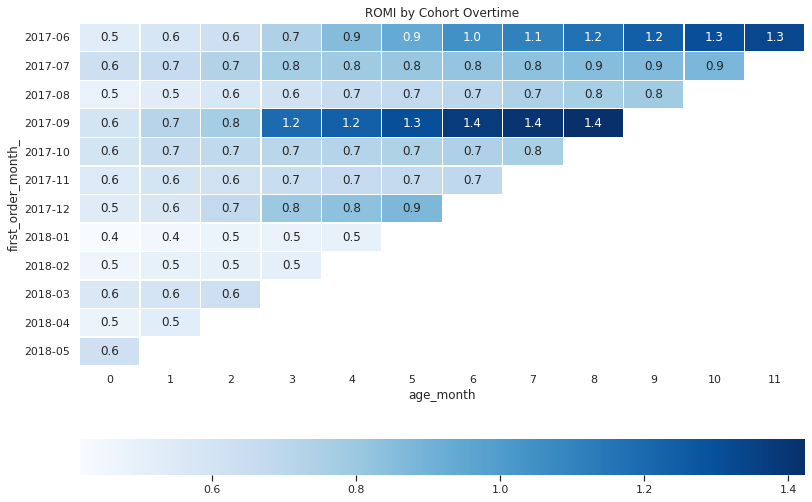

In [107]:
# visualize romi
## initialize pivot table
romi_cohort = (cohorts_report
               .pivot_table(index='first_order_month_',
                            columns='age_month',
                            values='romi',
                            aggfunc='mean'
                            )
               .cumsum(axis=1)
              )

## create heatmap
plt.figure(figsize=(13,9))
plt.title('ROMI by Cohort Overtime')
sns.heatmap(romi_cohort,
            annot=True,
            cmap='Blues',
            linecolor='white',
            linewidths=0.3,
            fmt='.1f',
            cbar_kws= {'orientation': 'horizontal'}
           );

In [108]:
# calculate the average romi
romi_cohort.mean(axis=0)

age_month
0     0.540816
1     0.581985
2     0.631069
3     0.719740
4     0.782946
5     0.859876
6     0.896819
7     0.969951
8     1.053871
9     0.964488
10    1.094658
11    1.333982
dtype: float64

##### Based on Marketing Channel

**Calculate CAC (Customer Acquisition Cost)**

In [109]:
# STEP1 : filter the customers
## get the first `source_id` of each customer

## get `uid` first visit time
## then get the first `source_id` from the first visit
users = visits_clean.sort_values('start_ts').groupby('uid').first()
users = users[['source_id']]

# filter only `uid` that make first order
customers = visits_clean.merge(first_orders, on='uid', how='inner')

# merge `users` and `customers`
## get the first `source_id` for `customers` from `users`
customers = customers.join(users, on='uid', lsuffix='_visit', rsuffix='_first_order')
customers['first_order'] = customers['first_order'].astype('datetime64[D]')

#--------------------------------------------------------------------------------------
# STEP2: create cohort sizes for each marketing channel
## using`customers` data frame
customers_cohorts_sizes = (customers
                           .groupby(['source_id_first_order', 'first_order_month'], as_index=False)
                           .agg({'uid': 'nunique'})
                          )

customers_cohorts_sizes.rename(columns={'uid': 'initial_customers'}, inplace=True)

#--------------------------------------------------------------------------------------
# STEP3: get monthly costs from each source
## group and calculate costs by marketing channel per month
costs_source_month =(costs
                     .groupby(['source_id', 'month_'], as_index=False)
                     .agg({'costs':'sum'})
                    )


#--------------------------------------------------------------------------------------
# STEP4: calculate cac based on cohort in each `source_id`
## merge the `customers_cohorts_sizes` and the `costs_source_month`
source_cohorts_cac_report = (customers_cohorts_sizes
                         .merge(costs_source_month,
                                left_on=['source_id_first_order', 'first_order_month'],
                                right_on=['source_id', 'month_'])
                         .drop(['source_id_first_order', 'month_'], axis=1)
                        )

## calculate cac
source_cohorts_cac_report['cac'] = source_cohorts_cac_report['costs']/source_cohorts_cac_report['initial_customers']

#--------------------------------------------------------------------------------------
# check the result
print('total rows:', len(source_cohorts_cac_report))
source_cohorts_cac_report.head()

total rows: 84


first_order_month  initial_customers  source_id    costs       cac
0        2017-06-01                190          1  1125.61  5.924263
1        2017-07-01                160          1  1072.88  6.705500
2        2017-08-01                113          1   951.81  8.423097
3        2017-09-01                227          1  1502.01  6.616784
4        2017-10-01                340          1  2315.75  6.811029

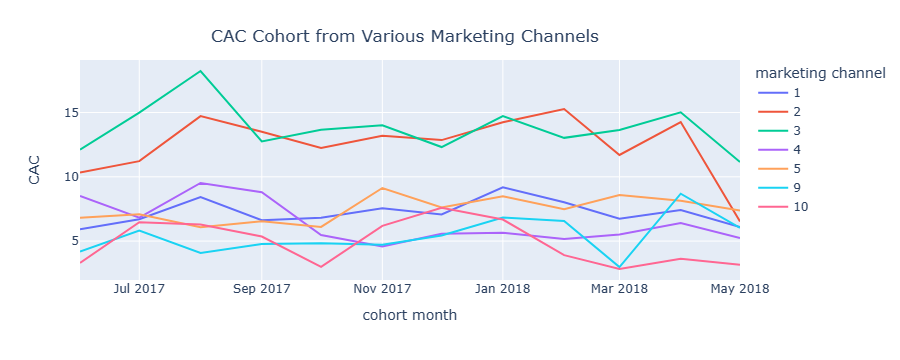

In [110]:
# create pivot table: monthly cac by source_id
cac_source_cohort = source_cohorts_cac_report.pivot_table(index='first_order_month',
                                                      columns='source_id',
                                                      values='cac',
                                                      aggfunc='mean')

# plot monthly cac by source_id
(px
 .line(cac_source_cohort)
 .update_layout(title={'text': "CAC Cohort from Various Marketing Channels",
                       'xanchor': 'center',
                       'x':0.45,
                       'yanchor': 'top'},
                yaxis_title="CAC",
                xaxis_title="cohort month",
                legend_title="marketing channel"
               )
 .show()
)

**Calculate ROMI (Return-on-Marketing-Investment)**

In [111]:
# create monthly revenue from each user 
uid_month_revenue = (orders_clean
                     .groupby(['uid', 'order_month'], as_index=False)
                     .agg({'revenue': 'sum'})
                    )

# add monthly revenue from each user to `customers`
## merge `customers` and `uid_month_revenue`
customers = customers.merge(uid_month_revenue, on = 'uid')

In [112]:
# check the results
# take only relevant data
customers = customers[['source_id_first_order', 'uid', 'first_order_month', 'order_month', 'revenue']]
customers.drop_duplicates(inplace=True)

print('total rows:', len(customers))
customers.head()

total rows: 41018


source_id_first_order                   uid first_order_month order_month  \
0                       4  16174680259334210214        2018-03-01  2018-03-01   
2                       5  16007536194108375387        2017-09-01  2017-09-01   
3                       5  16007536194108375387        2017-09-01  2017-10-01   
24                      2   8056418121947262981        2017-06-01  2017-06-01   
25                      2   8056418121947262981        2017-06-01  2017-09-01   

    revenue  
0      2.33  
2      2.44  
3      3.06  
24    42.78  
25    70.03

In [113]:
# validate the result
## the modified table should have the same revenue as the main dataset
customers['revenue'].sum() == orders_clean['revenue'].sum()

True

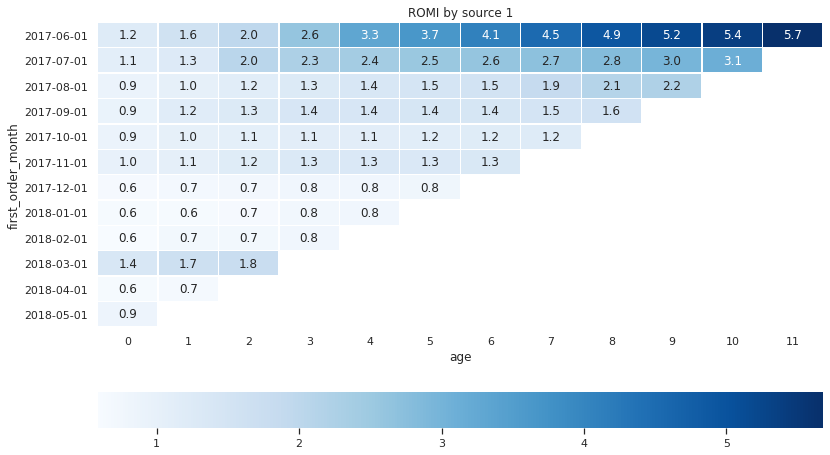

age
0     0.892768
1     1.048742
2     1.258675
3     1.363425
4     1.565990
5     1.768576
6     2.038114
7     2.362370
8     2.860597
9     3.462846
10    4.256256
11    5.679045
dtype: float64


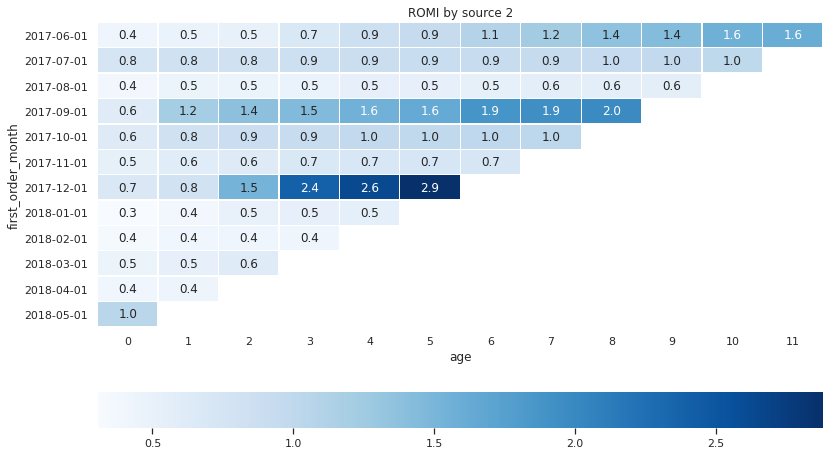

age
0     0.549286
1     0.630051
2     0.777428
3     0.939189
4     1.085749
5     1.229496
6     1.029998
7     1.140317
8     1.215401
9     0.994079
10    1.290747
11    1.612957
dtype: float64


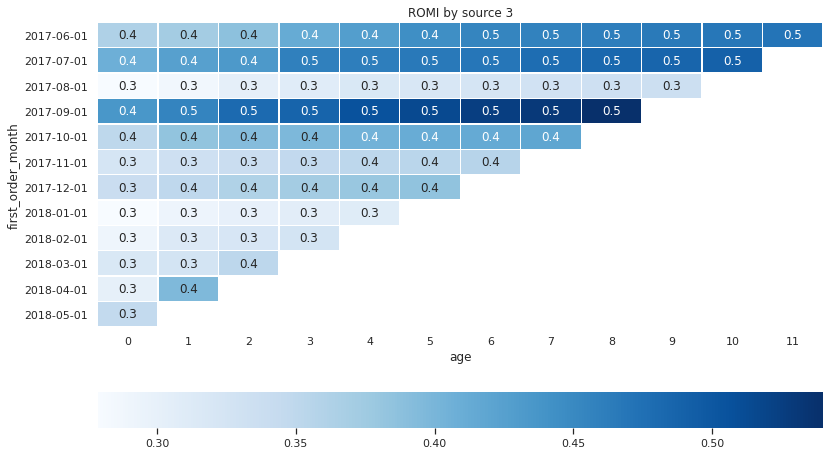

age
0     0.336151
1     0.357750
2     0.367152
3     0.379767
4     0.394988
5     0.413851
6     0.423732
7     0.442706
8     0.454574
9     0.429613
10    0.479128
11    0.470834
dtype: float64


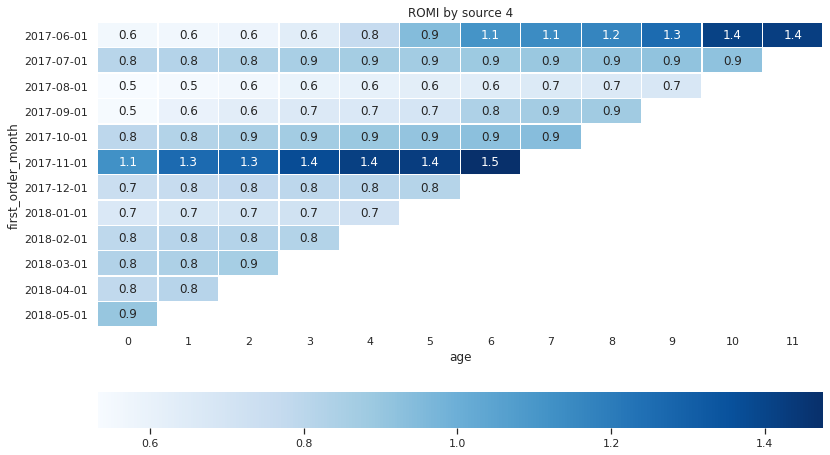

age
0     0.757409
1     0.776915
2     0.791630
3     0.814921
4     0.843845
5     0.900297
6     0.980375
7     0.900496
8     0.904477
9     0.952753
10    1.165144
11    1.420471
dtype: float64


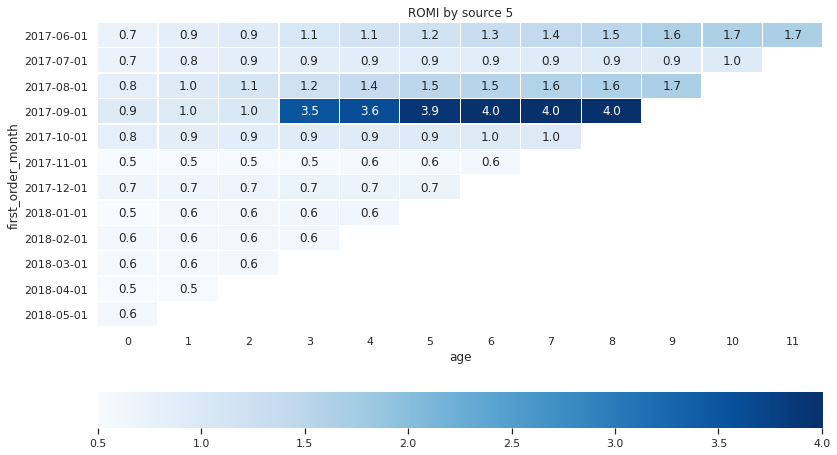

age
0     0.664923
1     0.718179
2     0.779610
3     1.111582
4     1.231647
5     1.387731
6     1.549131
7     1.783598
8     2.016601
9     1.415622
10    1.306381
11    1.673333
dtype: float64


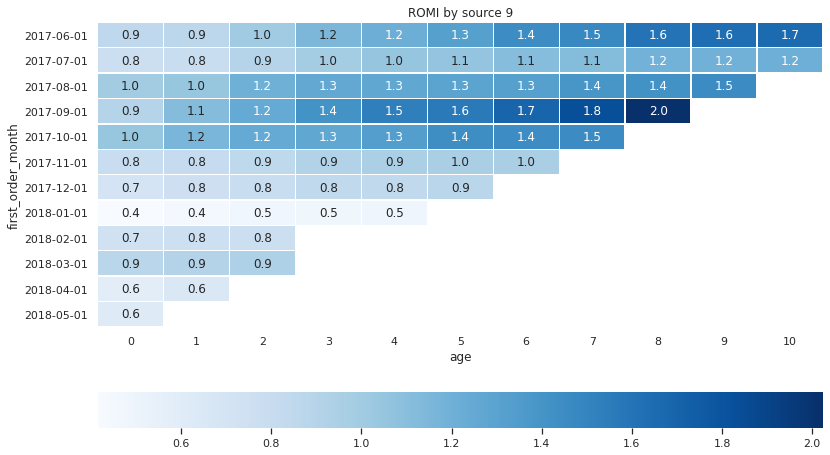

age
0     0.774013
1     0.847641
2     0.943664
3     1.041018
4     1.086613
5     1.216218
6     1.331051
7     1.455936
8     1.559885
9     1.428569
10    1.432871
dtype: float64


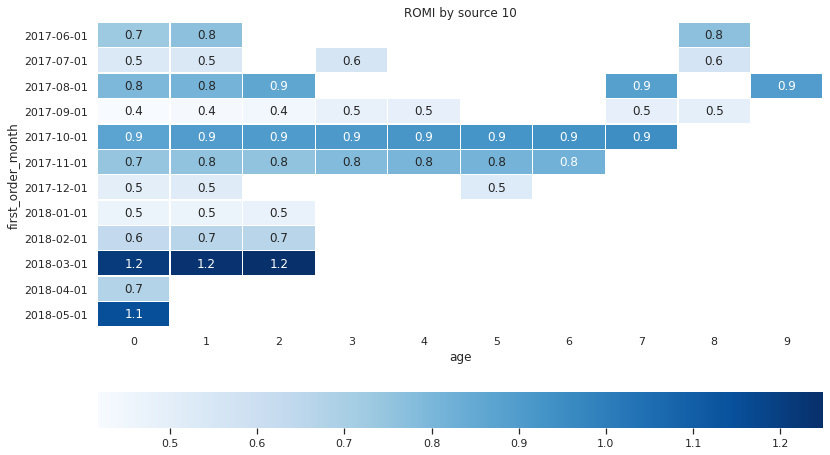

age
0    0.727377
1    0.708520
2    0.765743
3    0.685040
4    0.737312
5    0.754071
6    0.876620
7    0.773929
8    0.608024
9    0.899557
dtype: float64


In [114]:
# calculate romi
# loop through marketing channels (source_id_first_order)
# exclude marketing channel == 7

for source, df in customers.groupby('source_id_first_order'):
    if source !=7:
        
        # get cohort size
        cohort_sizes_t = (df
                          .groupby(['source_id_first_order', 'first_order_month'])
                          .agg({'uid': 'nunique'})
                          .reset_index()
                         )
        
        cohort_sizes_t.columns = ['source_id', 'first_order_month', 'initial_customers']
        
        # -------------------------------------------------------------------------------------
        # get cohort's revenue per month
        cohorts_revenue_t = (df
                             .groupby(['source_id_first_order', 'first_order_month', 'order_month'])
                             .agg({'revenue': 'sum'})
                             .reset_index()
                            )
        
        cohorts_revenue_t.columns = ['source_id', 'first_order_month', 'order_month', 'gp']
        
        # -------------------------------------------------------------------------------------
        # aggregate cohort sizes and cohort revenue
        report_romi = cohort_sizes_t.merge(cohorts_revenue_t, on=['source_id', 'first_order_month'])
        
        # -------------------------------------------------------------------------------------
        # calculate age
        report_romi['age'] = (report_romi['order_month'] - report_romi['first_order_month'])/np.timedelta64(1, 'M')
                              
        report_romi['age'] = report_romi['age'].round().astype('int')
        
        # -------------------------------------------------------------------------------------
        # calculate ltv
        report_romi['ltv'] = report_romi['gp'] / report_romi['initial_customers']
        
        # -------------------------------------------------------------------------------------
        # add marketing channel costs per month
        report_romi = report_romi.merge(costs_source_month,
                                        left_on=['source_id', 'first_order_month'],
                                        right_on=['source_id', 'month_'])
        
        
        report_romi = report_romi.drop(['month_'], axis = 1) 
        
        # -------------------------------------------------------------------------------------
        # calculate cac
        report_romi['cac'] = report_romi['costs'] / report_romi['initial_customers']
        
        # -------------------------------------------------------------------------------------
        # calculate romi
        report_romi['romi'] = report_romi['ltv'] / report_romi['cac']

        # -------------------------------------------------------------------------------------
        # build romi report
        romi = report_romi\
                .pivot_table(index='first_order_month',
                             columns='age',
                             values='romi',
                             aggfunc='mean')\
                .cumsum(axis=1)
        
        romi.fillna('')
        
        romi.index=romi.index.astype(str)

        # -------------------------------------------------------------------------------------
        # visualize romi report
        plt.figure(figsize=(13,8))
        sns.heatmap(romi, annot=True,
                    fmt='.1f', linewidths=0.3,
                    linecolor='white',
                    cbar_kws= {'orientation': 'horizontal'},
                    cmap='Blues'
            ).set(title ='ROMI by source {}'.format(source))
        plt.show()
        
        print(romi.mean(axis=0))

#### Insight
**INSIGHT:**    
**CAC and ROMI based on cohort**
- The CAC during June 2017-May 2018 is around 7.44-10.8 USD
- The ROMI analysis suggested the marketing expenses recouped after the cohort age was eight months and started generating profit at ten months
- Ideally, the healthy business has an LTV/CAC ratio of 3:1 (ROMI >3). It means we should make 3x revenue from what we spend on acquiring customers.
- In this case, the average ROMI from all cohorts haven't generated the ideal ROMI  after 11 months

**CAC and ROMI based on Marketing Channel**
- Assume we target the marketing expenses should recoup in 6 months, we can conclude that source_id 1,2, 5, and 9 can satisfy this target.
- All cohorts from source_id 1 could recoup the marketing costs in 1 month, even having an average ROMI of 2.04 in 6 months. After 11 months, this source could yield 5.6x revenue from the marketing cost (ROMI=)
- All cohorts in source_id 2 could recoup the marketing expenses in 4 months 
- All cohorts in source_id 5 and 9 could recoup the marketing expenses in 3 months. 
- After 11 months, the source_id 2,5, and 9 yielded revenue no more than 60% from the marketing cost (ROMI < 1.6)
- All cohorts in source_id 3, 4, and 10 couldn't recoup even after 11 months
- The marketing channel that has high CAC: source_id 3 and 2
- The rest marketing channels have almost similar CAC


**RECOMMENDATION:**
- It's better to make a comparison to a similar business/benchmark to evaluate whether this result is considered normal or underperforms
- We need to reallocate (even cut out) several marketing channels that are not effective in leveraging the marketing cost and gaining revenue
- It's advisable to reallocate the marketing cost to the marketing channel that costs lower but could yield higher ROMI in a shorter period

## STAGE 4 - Conclusion

- This project analysis aims to evaluate the marketing expenses of Y.Afisha. We conducted several studies to determine how people use the product, when they start buying, how much money each customer brings, and when they pay it off. <br>


- In the First and Second Stages, we reloaded the data and conducted data preprocessing. All datasets contain no missing values and duplicate rows. The Data Preprocessing perform datatype adjustments, formatting, adding modified datasets, and truncating datetime to the primary dataset for analysis convenience.<br>


- In the Third Stage, we conducted cohort analysis which was divided into three sections (i.e., user engagement, sales KPI, and marketing) <br>


- **The user engagement analysis** shows that the weekly and monthly stickiness of the platform is low, and boosting user engagement is recommended to increase the possibility of users making an order. The average session visit spiked in December 2017 and reduced in April 2018, suggesting the need to identify the cause of these anomalies. The distribution of session duration is right-skewed, with most visits being short. The retention rate has dropped significantly since the first month. We need to immediately identify the low retention cause since the first month/week/even visit is critical. More than 92% of users have stopped using the platform since the first month, and taking action to reduce the churn rate is necessary. The marketing activities in Jun, Aug, Sept, Oct, and Nov engaged users more. The recommendations include evaluating the improvement by calculating the stickiness metric, checking the cause of short user visits, identifying common retention causes, and taking measures to improve customer satisfaction, retention, and engagement.<br>


- The analysis looked at several **key performance indicators (KPIs) related to sales**. The first KPI was conversion day, which looked at when new users made their first order. The analysis found that most new users made their first order on day 0, with a conversion rate of over 10%. The analysis recommended investigating the reason behind this high conversion rate. The analysis also looked at conversion day based on marketing channels and found that some channels had longer conversion days than others. The second KPI was the number of orders per customer, and the analysis found that most customers made 1-2 orders over time. The analysis provided several possible reasons for this consistency and recommended different strategies to increase the number of orders per customer. The third KPI was purchase size, which found that the average purchase size was around 4-8 USD. The analysis found that the right offering could boost purchase size, and repeated orders yielded higher purchase size over time. The final KPI was the average lifetime value (LTV) for all cohorts, which was found to be 11.88 USD. The analysis found that cohorts from 2017 tended to bring higher LTV than cohorts from 2018, and there were surges in some cohorts that increased their LTV.<br>



- The **marketing analysis** shows that the total marketing cost increased from 2017-09, then gradually decreased. Several marketing channels (especially 3 and 2) seem to be less effective than others (4 and 1). The marketing cost aligns with the number of new users gained. Therefore, it is recommended to reallocate the marketing cost to channels that are more efficient and cost-effective.<br>


- The CAC during June 2017-May 2018 was around 7.44-10.8 USD. The ROMI analysis suggested that the marketing expenses recouped after the cohort age was eight months and started generating profit at ten months. Ideally, the healthy business has an LTV/CAC ratio of 3:1. All cohorts in source_id 3, 4, and 10 couldn't recoup the marketing expenses even after 11 months. Therefore, it is recommended to cut out or reallocate marketing expenses from ineffective channels and allocate more to those that can generate higher ROMI in a shorter period.<br>